In [1]:
import sys
from fastai.vision import *
from fastai.vision import Image
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL
from skimage.transform import resize
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from IPython.display import clear_output

In [2]:
learn = None
cap = None
out = None

path = Path('/storage')
path_img = path/'vocal_cords_and_rings_data/data/classifier'
path_img = path_img.resolve()

In [3]:
data = ImageDataBunch.from_folder(path_img, train=".", valid_pct=0.15,
                                  ds_tfms=get_transforms(flip_vert=True),
                                  size=224,
                                  num_workers=4)
class_dict={0:'larynx',1:'subglottis',2:'trachea', 3:'bifurcation'}

learn = cnn_learner(data, models.resnet50, metrics=error_rate);
learn.load('stage-2-new');

In [4]:
#Deprecated:
def float_to_uint(output):
    info = np.finfo(output.dtype) # Get the information of the incoming image type
    output = output.astype(np.float64) / info.max # normalize the data to 0 - 1
    output = 255 * output # Now scale by 255
    ret = output.astype(np.uint8)
    return ret

In [5]:
def overlay_mask(img, mask, show=False):
    alpha = 0.6
    beta = (1-alpha)
    output = cv2.addWeighted(img, alpha, mask.astype('float'), beta, 0.0)

    if show:
        rgb_ = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_)
        plt.show()
    
    return output

In [145]:
def crop_img(img,shape):
    cropx=np.min(img.shape[:2])
    cropy=cropx
    y,x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)   
    print("SHAPE {}, {}".format(img.shape[0],img.shape[1]))
    return resize(img,(480,480),anti_aliasing=True) #dtype = float64

In [146]:
def mask_to_colour(mask,colour=[0,255,0]):
    output_mask = np.zeros((mask.shape[0],mask.shape[1],3)).astype(np.uint8)
    green = [0,255,0]
    red = [255,0,0]
    blue = [0,0,255]
    other = [150,200,0]
    output_mask[mask==1]=red
    output_mask[mask==2]=green
    output_mask[mask==3]=blue
    return output_mask


In [147]:
#Swaps the r and b channels, for converting between PIL Image and Opencv BGR nparray
def red_blue_swap(img):
    return img[:, :, ::-1]

In [148]:
cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
out = cv2.VideoWriter('/storage/vocal_cords_and_rings_data/nbs/classification-stage-2-rn50.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30.0, (480,480))
print ("Cap fps: {}".format(cap.get(cv2.CAP_PROP_FPS)))
ctr = 0

######PARAMS######
#fps of the input video
fps=30
#start time for annotation (in seconds)
start_time_s= 10
#end time for annotation (in seconds)
end_time_s = 60*3+15
###ENDOF PARAMS###


Cap fps: 29.97002997002997


In [149]:
#Advance to starting frame
for i in range(0,start_time_s*fps):
    ret, frame = cap.read()
    ctr+=1
    
clear_output()
print ("Starting!")
while(cap.isOpened() and ctr <end_time_s*fps):

    ctr+=1
    print(ctr)
    
    ret, frame = cap.read() #frame is uint8
    if np.shape(frame) == (): #i.e. empty frame
        break
        
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    #Predict
    t = PIL.Image.fromarray(frame_rgb)
    t = pil2tensor(t.convert("RGB"), np.float32).div_(255)
    t = Image(t)
    pred_class,pred_idx,outputs = learn.predict(t)
    
        
    main = "{0:.2f}".format(float("{0:.2f}".format(max(outputs)*100.0)))
    second = "{0:.2f}".format(float(np.sort(outputs)[-2]*100.0))
#     main = 7
#     print(main)
#     print(second)

    outputs = np.array(outputs).tolist()
    print(outputs)
    #Convert from OpenCV image to pytorch tensor, to Image
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #frame_rgb is uint8
    cv2.putText(frame,"{}: {}".format(class_dict[outputs.index(np.max(outputs))],main),(5,25),cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,255,0),2)
    cv2.putText(frame,"{}: {}".format(class_dict[outputs.index(np.sort(outputs)[-2])],second),(5,55),cv2.FONT_HERSHEY_COMPLEX,0.9,(170,170,170),2)
#     plt.imshow(red_blue_swap(frame))
#     plt.show()

    cr=crop_img(frame,(frame.shape[0],frame.shape[1])) 
#     cr = np.array(frame)
#     print(cr.shape)
#     cr.astype(np.float)
    # Write uint8 version of ov to output video
    print(cr.dtype)
    out.write(img_as_ubyte(cr))
    
cap.release()
out.release()
print ("End!")

Starting!
301
[0.9967948794364929, 0.0010393111733719707, 0.0006862826994620264, 0.0014796461910009384]
SHAPE 480, 720
float64
302
[0.9923887848854065, 0.002746606944128871, 0.0020432572346180677, 0.00282129249535501]
SHAPE 480, 720
float64
303
[0.9954634308815002, 0.0016165378037840128, 0.0008730815607123077, 0.002047085203230381]
SHAPE 480, 720
float64
304
[0.9965718984603882, 0.001182651030831039, 0.0007230420596897602, 0.0015224488452076912]
SHAPE 480, 720
float64
305
[0.998178243637085, 0.0005387687124311924, 0.0004989648587070405, 0.0007839835016056895]
SHAPE 480, 720
float64
306
[0.9992032647132874, 0.0003847775515168905, 0.00021932327945251018, 0.00019277510000392795]
SHAPE 480, 720
float64
307
[0.9997783303260803, 0.00011424012336647138, 3.8765738281654194e-05, 6.86375133227557e-05]
SHAPE 480, 720
float64
308
[0.9988963603973389, 0.0004983136313967407, 0.00017464526172261685, 0.00043061774340458214]
SHAPE 480, 720
float64
309
[0.9974780678749084, 0.0011482100235298276, 0.00066

float64
373
[0.9988589286804199, 0.000550171360373497, 0.0002527967153582722, 0.0003381977730896324]
SHAPE 480, 720
float64
374
[0.9988304972648621, 0.0006243068492040038, 0.00020608384511433542, 0.0003391267091501504]
SHAPE 480, 720
float64
375
[0.9989928603172302, 0.0004840137844439596, 0.0002476060763001442, 0.0002755428431555629]
SHAPE 480, 720
float64
376
[0.9994483590126038, 0.0003610117710195482, 0.00010620519606163725, 8.448179141851142e-05]
SHAPE 480, 720
float64
377
[0.9985873699188232, 0.0010062124347314239, 0.00019805412739515305, 0.0002083240106003359]
SHAPE 480, 720
float64
378
[0.9970030188560486, 0.0017245166236534715, 0.000728015264030546, 0.0005444725975394249]
SHAPE 480, 720
float64
379
[0.9996519088745117, 0.00014751707203686237, 0.00010483327059773728, 9.565160871716216e-05]
SHAPE 480, 720
float64
380
[0.9994910955429077, 0.00030126169440336525, 0.00010034277511294931, 0.0001073032763088122]
SHAPE 480, 720
float64
381
[0.9993506073951721, 0.00036721632932312787, 0.

[0.9548043012619019, 0.03387964144349098, 0.004218267276883125, 0.007097797002643347]
SHAPE 480, 720
float64
446
[0.9859262704849243, 0.008413548581302166, 0.0016781744780018926, 0.003981978632509708]
SHAPE 480, 720
float64
447
[0.9467335939407349, 0.03546849265694618, 0.005242594052106142, 0.012555412016808987]
SHAPE 480, 720
float64
448
[0.9516465067863464, 0.02624071016907692, 0.008256007917225361, 0.013856710866093636]
SHAPE 480, 720
float64
449
[0.9877552390098572, 0.004592609591782093, 0.004011528100818396, 0.0036407066509127617]
SHAPE 480, 720
float64
450
[0.9966784715652466, 0.0013967660488560796, 0.0013696332462131977, 0.0005551116191782057]
SHAPE 480, 720
float64
451
[0.991731584072113, 0.0028214924968779087, 0.002893658820539713, 0.0025533309672027826]
SHAPE 480, 720
float64
452
[0.9968219995498657, 0.0009928097715601325, 0.0010635980870574713, 0.0011214733822271228]
SHAPE 480, 720
float64
453
[0.9968339800834656, 0.0013904259540140629, 0.0006071553216315806, 0.0011684645432

[0.9895749688148499, 0.0011420745868235826, 0.0036891696508973837, 0.0055938586592674255]
SHAPE 480, 720
float64
518
[0.9953879714012146, 0.0005397279746830463, 0.0009403664735145867, 0.0031319374684244394]
SHAPE 480, 720
float64
519
[0.9826852083206177, 0.000644743675366044, 0.0038753971457481384, 0.012794648297131062]
SHAPE 480, 720
float64
520
[0.9878877401351929, 0.0008181090233847499, 0.005453960970044136, 0.00584020558744669]
SHAPE 480, 720
float64
521
[0.9983099699020386, 0.00016485393280163407, 0.0005756717291660607, 0.0009495418635196984]
SHAPE 480, 720
float64
522
[0.9946613907814026, 0.0005880857934243977, 0.002257975982502103, 0.0024925058241933584]
SHAPE 480, 720
float64
523
[0.9901056885719299, 0.0006568937678821385, 0.0017349530244246125, 0.00750258844345808]
SHAPE 480, 720
float64
524
[0.9849588871002197, 0.002871518023312092, 0.0017050410388037562, 0.010464553721249104]
SHAPE 480, 720
float64
525
[0.9809454679489136, 0.0016099013155326247, 0.0029418596532195807, 0.0145

[0.9946764707565308, 0.00213834666647017, 0.00033057559630833566, 0.0028545218519866467]
SHAPE 480, 720
float64
591
[0.9950491786003113, 0.0026988061144948006, 0.0002492111816536635, 0.002002810826525092]
SHAPE 480, 720
float64
592
[0.998415470123291, 0.0005707876407541335, 0.00014413835015147924, 0.0008695068536326289]
SHAPE 480, 720
float64
593
[0.9945173859596252, 0.0019333268282935023, 0.0006027620984241366, 0.0029465730767697096]
SHAPE 480, 720
float64
594
[0.9951233267784119, 0.002119798678904772, 0.0005015979404561222, 0.002255410421639681]
SHAPE 480, 720
float64
595
[0.9938275218009949, 0.0016260900301858783, 0.00047208982869051397, 0.004074324853718281]
SHAPE 480, 720
float64
596
[0.9923815131187439, 0.002477450994774699, 0.0006622393848374486, 0.0044787186197936535]
SHAPE 480, 720
float64
597
[0.9932490587234497, 0.0014703947817906737, 0.0007807889487594366, 0.004499800968915224]
SHAPE 480, 720
float64
598
[0.9977993369102478, 0.0007112069288268685, 0.0003542065969668329, 0.0

663
[0.9977364540100098, 0.000255854451097548, 0.000293867225991562, 0.0017138466937467456]
SHAPE 480, 720
float64
664
[0.9972781538963318, 0.00043643766548484564, 0.0002307538961758837, 0.0020546659361571074]
SHAPE 480, 720
float64
665
[0.9950189590454102, 0.0019636594224721193, 0.0003784644650295377, 0.0026388883125036955]
SHAPE 480, 720
float64
666
[0.9913716316223145, 0.0018814854556694627, 0.00033614449785090983, 0.006410785485059023]
SHAPE 480, 720
float64
667
[0.9956105351448059, 0.001437110942788422, 0.0002154381654690951, 0.002736861351877451]
SHAPE 480, 720
float64
668
[0.996367335319519, 0.0012030088109895587, 0.0001238389522768557, 0.002305749338120222]
SHAPE 480, 720
float64
669
[0.9980810880661011, 0.0009001565631479025, 6.547148223035038e-05, 0.0009532442199997604]
SHAPE 480, 720
float64
670
[0.9985482096672058, 0.0005536752287298441, 9.665346442488953e-05, 0.0008015242638066411]
SHAPE 480, 720
float64
671
[0.9969273209571838, 0.0008348546689376235, 0.0001288609637413174

float64
735
[0.9994589686393738, 0.00038403968210332096, 2.2584938051295467e-05, 0.00013437085726764053]
SHAPE 480, 720
float64
736
[0.999687910079956, 8.708528184797615e-05, 2.4907891202019528e-05, 0.00020003569079563022]
SHAPE 480, 720
float64
737
[0.9982174038887024, 0.0007919740164652467, 0.00016110525757540017, 0.0008294953731819987]
SHAPE 480, 720
float64
738
[0.9988334774971008, 0.000396812247345224, 0.00012848251208197325, 0.0006412136135622859]
SHAPE 480, 720
float64
739
[0.9984773993492126, 0.0005579052958637476, 8.073748176684603e-05, 0.0008839638903737068]
SHAPE 480, 720
float64
740
[0.9980289340019226, 0.0009106445359066129, 0.00010778613795991987, 0.0009525878122076392]
SHAPE 480, 720
float64
741
[0.998984158039093, 0.0004493818851187825, 0.00015135839930735528, 0.00041498354403302073]
SHAPE 480, 720
float64
742
[0.9972221851348877, 0.002414307789877057, 3.907737118424848e-05, 0.00032444557291455567]
SHAPE 480, 720
float64
743
[0.9987114667892456, 0.0005437058280222118, 0

[0.9944019913673401, 0.0030753486789762974, 0.0006192730506882071, 0.0019033858552575111]
SHAPE 480, 720
float64
807
[0.9729062914848328, 0.0158291757106781, 0.0010934543097391725, 0.010171020403504372]
SHAPE 480, 720
float64
808
[0.9771454334259033, 0.01019068993628025, 0.0013955081813037395, 0.01126833539456129]
SHAPE 480, 720
float64
809
[0.965423047542572, 0.013170898891985416, 0.0024741627275943756, 0.018931861966848373]
SHAPE 480, 720
float64
810
[0.9871692657470703, 0.004658429883420467, 0.0024825322907418013, 0.005689734127372503]
SHAPE 480, 720
float64
811
[0.9870346188545227, 0.006062183063477278, 0.0007397437584586442, 0.00616348534822464]
SHAPE 480, 720
float64
812
[0.9963902831077576, 0.001460955711081624, 0.0003759555402211845, 0.001772771356627345]
SHAPE 480, 720
float64
813
[0.981370747089386, 0.009791499935090542, 0.0015486825723201036, 0.007289134431630373]
SHAPE 480, 720
float64
814
[0.9487475752830505, 0.03568336367607117, 0.0034081244375556707, 0.012160911224782467

879
[0.6557526588439941, 0.06946200877428055, 0.012091996148228645, 0.2626933455467224]
SHAPE 480, 720
float64
880
[0.8528169989585876, 0.030658939853310585, 0.008523445576429367, 0.10800063610076904]
SHAPE 480, 720
float64
881
[0.7102264761924744, 0.11499176174402237, 0.019258910790085793, 0.15552282333374023]
SHAPE 480, 720
float64
882
[0.9522069692611694, 0.008423930034041405, 0.002841994632035494, 0.03652706742286682]
SHAPE 480, 720
float64
883
[0.9574186205863953, 0.014796256087720394, 0.006342702079564333, 0.021442459896206856]
SHAPE 480, 720
float64
884
[0.9700297713279724, 0.012853232212364674, 0.00409217644482851, 0.013024886138737202]
SHAPE 480, 720
float64
885
[0.9678482413291931, 0.013752243481576443, 0.006053783465176821, 0.012345713563263416]
SHAPE 480, 720
float64
886
[0.9692091345787048, 0.01184840314090252, 0.00290353293530643, 0.016038917005062103]
SHAPE 480, 720
float64
887
[0.9730578064918518, 0.0076904757879674435, 0.0034144707024097443, 0.015837106853723526]
SHAPE

954
[0.5000324249267578, 0.42067840695381165, 0.018945571035146713, 0.06034361198544502]
SHAPE 480, 720
float64
955
[0.4413668215274811, 0.5031376481056213, 0.02510608360171318, 0.030389444902539253]
SHAPE 480, 720
float64
956
[0.4980071187019348, 0.40114694833755493, 0.022984404116868973, 0.07786162197589874]
SHAPE 480, 720
float64
957
[0.5966613292694092, 0.30707356333732605, 0.02226516604423523, 0.0740000382065773]
SHAPE 480, 720
float64
958
[0.501833438873291, 0.4188113808631897, 0.020355047658085823, 0.059000082314014435]
SHAPE 480, 720
float64
959
[0.13734206557273865, 0.7557603120803833, 0.02467954158782959, 0.08221800625324249]
SHAPE 480, 720
float64
960
[0.020033475011587143, 0.9192786812782288, 0.007074624300003052, 0.05361330136656761]
SHAPE 480, 720
float64
961
[0.2021530419588089, 0.7231841087341309, 0.01798972673714161, 0.05667310953140259]
SHAPE 480, 720
float64
962
[0.09993680566549301, 0.8028363585472107, 0.01714416965842247, 0.08008264005184174]
SHAPE 480, 720
float64

1027
[0.7071987986564636, 0.2317497730255127, 0.029846902936697006, 0.03120448626577854]
SHAPE 480, 720
float64
1028
[0.9286676049232483, 0.057948943227529526, 0.0037179680075496435, 0.00966550037264824]
SHAPE 480, 720
float64
1029
[0.8991187214851379, 0.0799136757850647, 0.00855814665555954, 0.012409327551722527]
SHAPE 480, 720
float64
1030
[0.9562862515449524, 0.03426338732242584, 0.004372661933302879, 0.005077676381915808]
SHAPE 480, 720
float64
1031
[0.9900424480438232, 0.006049619056284428, 0.002827384974807501, 0.0010805664351209998]
SHAPE 480, 720
float64
1032
[0.9788029789924622, 0.012183786369860172, 0.005750201642513275, 0.0032630139030516148]
SHAPE 480, 720
float64
1033
[0.9930353164672852, 0.004239104222506285, 0.0010454743169248104, 0.0016800555167719722]
SHAPE 480, 720
float64
1034
[0.974075436592102, 0.01870974339544773, 0.0023668811190873384, 0.0048479181714355946]
SHAPE 480, 720
float64
1035
[0.9801842570304871, 0.012524438090622425, 0.0023261329624801874, 0.0049651530

float64
1100
[0.9960594177246094, 0.00023936163051985204, 0.00086274987552315, 0.0028384211473166943]
SHAPE 480, 720
float64
1101
[0.9991627931594849, 9.89240434137173e-05, 0.00031472492264583707, 0.00042360846418887377]
SHAPE 480, 720
float64
1102
[0.9987927675247192, 0.000329771515680477, 0.00019346890621818602, 0.0006838686531409621]
SHAPE 480, 720
float64
1103
[0.9984669089317322, 0.000457518472103402, 0.0002466687001287937, 0.0008288667886517942]
SHAPE 480, 720
float64
1104
[0.9931315779685974, 0.0015311939641833305, 0.0011653931578621268, 0.0041718753054738045]
SHAPE 480, 720
float64
1105
[0.9938001036643982, 0.0009384537115693092, 0.0018014160450547934, 0.0034600351937115192]
SHAPE 480, 720
float64
1106
[0.992203950881958, 0.0005854801856912673, 0.003807966597378254, 0.003402585396543145]
SHAPE 480, 720
float64
1107
[0.9753815531730652, 0.004427972715348005, 0.007858467288315296, 0.01233209390193224]
SHAPE 480, 720
float64
1108
[0.9886301755905151, 0.0019038950558751822, 0.00385

float64
1172
[0.9846549034118652, 0.00479862792417407, 0.0017091271001845598, 0.00883725006133318]
SHAPE 480, 720
float64
1173
[0.9897083640098572, 0.004382499027997255, 0.0008486435981467366, 0.00506048696115613]
SHAPE 480, 720
float64
1174
[0.9816082119941711, 0.0074443514458835125, 0.002804284915328026, 0.008143085055053234]
SHAPE 480, 720
float64
1175
[0.9888660311698914, 0.0052627925761044025, 0.0014357799664139748, 0.004435358103364706]
SHAPE 480, 720
float64
1176
[0.9848421812057495, 0.004942429717630148, 0.0036357727367430925, 0.006579707842320204]
SHAPE 480, 720
float64
1177
[0.9728693962097168, 0.008317322470247746, 0.003575112670660019, 0.01523815467953682]
SHAPE 480, 720
float64
1178
[0.9697582721710205, 0.009666685946285725, 0.0021784950513392687, 0.018396517261862755]
SHAPE 480, 720
float64
1179
[0.915025532245636, 0.034370359033346176, 0.007536519784480333, 0.043067704886198044]
SHAPE 480, 720
float64
1180
[0.9212172627449036, 0.028585877269506454, 0.01089190598577261, 0

float64
1246
[0.00043921760516241193, 0.8369811177253723, 0.022117266431450844, 0.14046241343021393]
SHAPE 480, 720
float64
1247
[0.00014522636774927378, 0.8761074542999268, 0.01717280223965645, 0.10657446086406708]
SHAPE 480, 720
float64
1248
[0.00020463758846744895, 0.9147074222564697, 0.012404076755046844, 0.07268387079238892]
SHAPE 480, 720
float64
1249
[0.0006703506805934012, 0.8294847011566162, 0.02367483638226986, 0.14617016911506653]
SHAPE 480, 720
float64
1250
[0.0003676980850286782, 0.8617584109306335, 0.02539944462478161, 0.11247442662715912]
SHAPE 480, 720
float64
1251
[0.000320190069032833, 0.9056846499443054, 0.018392421305179596, 0.075602687895298]
SHAPE 480, 720
float64
1252
[0.00043730877223424613, 0.8937627673149109, 0.017305729910731316, 0.08849422633647919]
SHAPE 480, 720
float64
1253
[0.0002799728245008737, 0.8872424960136414, 0.016778824850916862, 0.09569869190454483]
SHAPE 480, 720
float64
1254
[0.0004962957464158535, 0.9111495018005371, 0.013511640951037407, 0.0

float64
1320
[1.2821410564356484e-06, 0.9486892223358154, 0.015409557148814201, 0.03590003401041031]
SHAPE 480, 720
float64
1321
[1.1222837059676749e-07, 0.973230242729187, 0.010670005343854427, 0.016099754720926285]
SHAPE 480, 720
float64
1322
[2.4921783392528596e-07, 0.9516016244888306, 0.02858823910355568, 0.01980982907116413]
SHAPE 480, 720
float64
1323
[1.577430595034457e-07, 0.9605447053909302, 0.019807938486337662, 0.019647208973765373]
SHAPE 480, 720
float64
1324
[2.017431341982956e-07, 0.9703177809715271, 0.016462868079543114, 0.01321914978325367]
SHAPE 480, 720
float64
1325
[1.86173835459158e-07, 0.968066394329071, 0.017802584916353226, 0.014130772091448307]
SHAPE 480, 720
float64
1326
[7.0048031375336e-08, 0.9671927690505981, 0.01812235824763775, 0.014684694819152355]
SHAPE 480, 720
float64
1327
[3.7404745967251074e-07, 0.9393129944801331, 0.03766406327486038, 0.023022642359137535]
SHAPE 480, 720
float64
1328
[1.7862731738205184e-06, 0.9299059510231018, 0.04459512606263161, 

[3.895176178048132e-06, 0.17036399245262146, 0.8048945069313049, 0.02473754808306694]
SHAPE 480, 720
float64
1393
[1.6812074932204268e-07, 0.08608292043209076, 0.9046798944473267, 0.009237071499228477]
SHAPE 480, 720
float64
1394
[3.1274938194769675e-09, 0.11489418148994446, 0.882795512676239, 0.0023103051353245974]
SHAPE 480, 720
float64
1395
[2.5712472151440124e-09, 0.20239296555519104, 0.7923294901847839, 0.005277438089251518]
SHAPE 480, 720
float64
1396
[7.873103280431337e-10, 0.054526980966329575, 0.9446668028831482, 0.0008062139386311173]
SHAPE 480, 720
float64
1397
[1.0761500579548056e-09, 0.11753982305526733, 0.8816235065460205, 0.0008367246482521296]
SHAPE 480, 720
float64
1398
[1.0271446804210882e-08, 0.284294992685318, 0.7130964994430542, 0.002608504146337509]
SHAPE 480, 720
float64
1399
[7.580270300344694e-10, 0.1732824742794037, 0.8261414170265198, 0.0005759967025369406]
SHAPE 480, 720
float64
1400
[4.8813168784800354e-11, 0.20131321251392365, 0.7983712553977966, 0.0003155

float64
1463
[2.189779468864117e-10, 0.04118577018380165, 0.9579907059669495, 0.0008235591230913997]
SHAPE 480, 720
float64
1464
[5.069386577183366e-10, 0.048530347645282745, 0.950441837310791, 0.0010278347181156278]
SHAPE 480, 720
float64
1465
[1.2784652503317062e-10, 0.0352182611823082, 0.9639576077461243, 0.0008241608738899231]
SHAPE 480, 720
float64
1466
[2.5909890899455945e-10, 0.026318181306123734, 0.9726808667182922, 0.0010008793324232101]
SHAPE 480, 720
float64
1467
[7.713249483565221e-10, 0.02365754544734955, 0.9746378064155579, 0.0017046448774635792]
SHAPE 480, 720
float64
1468
[5.99753857688512e-10, 0.013041350990533829, 0.9857920408248901, 0.0011666184291243553]
SHAPE 480, 720
float64
1469
[2.600281101550195e-10, 0.020505374297499657, 0.9783537983894348, 0.001140882377512753]
SHAPE 480, 720
float64
1470
[1.06666664390076e-09, 0.028206385672092438, 0.9698623418807983, 0.001931218197569251]
SHAPE 480, 720
float64
1471
[2.4316432201132443e-10, 0.03215951472520828, 0.9665191173

float64
1536
[2.875439469862684e-12, 0.03991120308637619, 0.9600468277931213, 4.195257861283608e-05]
SHAPE 480, 720
float64
1537
[7.990303731164605e-12, 0.040978267788887024, 0.9589313864707947, 9.026031329995021e-05]
SHAPE 480, 720
float64
1538
[3.301216450809358e-13, 0.0684947595000267, 0.9314411878585815, 6.408193439710885e-05]
SHAPE 480, 720
float64
1539
[1.2950839185787988e-11, 0.07611749321222305, 0.9237169623374939, 0.00016557374328840524]
SHAPE 480, 720
float64
1540
[2.226534711810557e-12, 0.1543659269809723, 0.8454667925834656, 0.0001672643847996369]
SHAPE 480, 720
float64
1541
[3.853259725183911e-12, 0.09580578655004501, 0.9040806293487549, 0.00011356810136931017]
SHAPE 480, 720
float64
1542
[5.061129033229195e-12, 0.08817782998085022, 0.9117184281349182, 0.00010377533180871978]
SHAPE 480, 720
float64
1543
[4.62409060694724e-12, 0.016228631138801575, 0.9837340116500854, 3.729419768205844e-05]
SHAPE 480, 720
float64
1544
[3.4165042323008876e-11, 0.04617118835449219, 0.95370912

[1.0923763937853437e-07, 0.9766517281532288, 0.01563209667801857, 0.007716176100075245]
SHAPE 480, 720
float64
1609
[3.3256753795285476e-07, 0.961328387260437, 0.024844078347086906, 0.013827254995703697]
SHAPE 480, 720
float64
1610
[1.240247547684703e-05, 0.9461731910705566, 0.03979527950286865, 0.014019130729138851]
SHAPE 480, 720
float64
1611
[1.905098429233476e-06, 0.9571813344955444, 0.03286384791135788, 0.009952877648174763]
SHAPE 480, 720
float64
1612
[0.0010767076164484024, 0.7882487177848816, 0.15731197595596313, 0.05336271598935127]
SHAPE 480, 720
float64
1613
[1.3938009942648932e-05, 0.8079209923744202, 0.1646806299686432, 0.027384355664253235]
SHAPE 480, 720
float64
1614
[0.00010124274558620527, 0.7315213680267334, 0.22996735572814941, 0.03841005638241768]
SHAPE 480, 720
float64
1615
[2.691829649847932e-05, 0.8952859044075012, 0.06205480918288231, 0.04263237118721008]
SHAPE 480, 720
float64
1616
[8.013827937247697e-06, 0.9293709397315979, 0.014622729271650314, 0.055998440831

[1.5581598518110695e-06, 0.9784595966339111, 0.006485993042588234, 0.015052920207381248]
SHAPE 480, 720
float64
1683
[2.4148832267201215e-07, 0.9806963801383972, 0.010551822371780872, 0.008751582354307175]
SHAPE 480, 720
float64
1684
[5.950298032075807e-07, 0.9652671813964844, 0.026049179956316948, 0.00868310872465372]
SHAPE 480, 720
float64
1685
[7.648393989256874e-07, 0.9618897438049316, 0.02230261079967022, 0.015806900337338448]
SHAPE 480, 720
float64
1686
[5.733575747512987e-08, 0.970183789730072, 0.020000996068120003, 0.009815197438001633]
SHAPE 480, 720
float64
1687
[3.9394060991071456e-07, 0.9477176666259766, 0.034674592316150665, 0.01760740950703621]
SHAPE 480, 720
float64
1688
[5.319783440427273e-07, 0.971880316734314, 0.019391942769289017, 0.008727116510272026]
SHAPE 480, 720
float64
1689
[6.081743322283728e-07, 0.9719702005386353, 0.022771961987018585, 0.005257274955511093]
SHAPE 480, 720
float64
1690
[6.058530743757728e-07, 0.9803077578544617, 0.01405187789350748, 0.0056397

float64
1754
[1.8121812672688975e-07, 0.9633051753044128, 0.024853788316249847, 0.01184078399091959]
SHAPE 480, 720
float64
1755
[6.917550763319014e-07, 0.9583410024642944, 0.027895430102944374, 0.013762874528765678]
SHAPE 480, 720
float64
1756
[1.6677389567121281e-06, 0.9550743699073792, 0.0227625984698534, 0.02216135524213314]
SHAPE 480, 720
float64
1757
[7.85805468694889e-07, 0.9609160423278809, 0.02218729257583618, 0.01689581573009491]
SHAPE 480, 720
float64
1758
[6.246219754757476e-07, 0.9492258429527283, 0.02875642105937004, 0.022016938775777817]
SHAPE 480, 720
float64
1759
[9.923275712253599e-08, 0.9482155442237854, 0.03475489094853401, 0.017029451206326485]
SHAPE 480, 720
float64
1760
[1.450495830113141e-07, 0.9671196341514587, 0.021614059805870056, 0.011266188696026802]
SHAPE 480, 720
float64
1761
[1.0207281064822382e-07, 0.966752290725708, 0.022858677431941032, 0.010388987138867378]
SHAPE 480, 720
float64
1762
[5.383020607041544e-07, 0.9506252408027649, 0.03240615501999855, 0

1825
[1.2954012163390871e-05, 0.975663423538208, 0.013466330245137215, 0.010857310146093369]
SHAPE 480, 720
float64
1826
[3.0664325549878413e-06, 0.9812009930610657, 0.012701649218797684, 0.00609426898881793]
SHAPE 480, 720
float64
1827
[1.215219799632905e-05, 0.9602611660957336, 0.031150616705417633, 0.0085761658847332]
SHAPE 480, 720
float64
1828
[1.1108386388514191e-05, 0.9707392454147339, 0.021644214168190956, 0.007605371065437794]
SHAPE 480, 720
float64
1829
[5.832158421981148e-06, 0.9734542965888977, 0.018681952729821205, 0.007857958786189556]
SHAPE 480, 720
float64
1830
[9.16875978873577e-06, 0.9672073721885681, 0.02168993093073368, 0.011093491688370705]
SHAPE 480, 720
float64
1831
[3.00679930660408e-05, 0.8909473419189453, 0.08998733758926392, 0.019035249948501587]
SHAPE 480, 720
float64
1832
[2.7896099709323607e-05, 0.9014802575111389, 0.07772555947303772, 0.020766321569681168]
SHAPE 480, 720
float64
1833
[1.7101943740271963e-05, 0.9248522520065308, 0.055688612163066864, 0.019

1898
[0.895000696182251, 0.02393658272922039, 0.019310418516397476, 0.06175224483013153]
SHAPE 480, 720
float64
1899
[0.47597217559814453, 0.05088859051465988, 0.12727788090705872, 0.34586137533187866]
SHAPE 480, 720
float64
1900
[0.8613343238830566, 0.017351005226373672, 0.020345797762274742, 0.10096890479326248]
SHAPE 480, 720
float64
1901
[0.4893585741519928, 0.19260424375534058, 0.08389370143413544, 0.23414351046085358]
SHAPE 480, 720
float64
1902
[0.9325962066650391, 0.023485712707042694, 0.01972167380154133, 0.02419639565050602]
SHAPE 480, 720
float64
1903
[0.9495968818664551, 0.014469186775386333, 0.01537249144166708, 0.020561479032039642]
SHAPE 480, 720
float64
1904
[0.8897888660430908, 0.03516571968793869, 0.025392793118953705, 0.04965260252356529]
SHAPE 480, 720
float64
1905
[0.9816327095031738, 0.003256445284932852, 0.008787507191300392, 0.006323365028947592]
SHAPE 480, 720
float64
1906
[0.979341447353363, 0.004390032961964607, 0.007459252141416073, 0.008809257298707962]
SHA

float64
1971
[0.8425195813179016, 0.11170613765716553, 0.02051209658384323, 0.025262175127863884]
SHAPE 480, 720
float64
1972
[0.11475839465856552, 0.7503268718719482, 0.06434869766235352, 0.07056606560945511]
SHAPE 480, 720
float64
1973
[0.05909205600619316, 0.7911037802696228, 0.041526779532432556, 0.10827739536762238]
SHAPE 480, 720
float64
1974
[0.05737920105457306, 0.8733948469161987, 0.01778569258749485, 0.051440320909023285]
SHAPE 480, 720
float64
1975
[0.076451376080513, 0.8141196966171265, 0.02706857956945896, 0.0823603942990303]
SHAPE 480, 720
float64
1976
[0.11607211828231812, 0.789769172668457, 0.03476574644446373, 0.05939299613237381]
SHAPE 480, 720
float64
1977
[0.061131104826927185, 0.8842523694038391, 0.019770776852965355, 0.03484576568007469]
SHAPE 480, 720
float64
1978
[0.17626172304153442, 0.7608665823936462, 0.01336338184773922, 0.049508336931467056]
SHAPE 480, 720
float64
1979
[0.32899290323257446, 0.6011244654655457, 0.024814777076244354, 0.04506782814860344]
SHAP

float64
2045
[0.8133883476257324, 0.15705901384353638, 0.010691644623875618, 0.018860962241888046]
SHAPE 480, 720
float64
2046
[0.8645628094673157, 0.09965511411428452, 0.015521769411861897, 0.020260436460375786]
SHAPE 480, 720
float64
2047
[0.928465723991394, 0.03926878422498703, 0.0207920353859663, 0.0114735197275877]
SHAPE 480, 720
float64
2048
[0.928602933883667, 0.04834308475255966, 0.008955496363341808, 0.014098543673753738]
SHAPE 480, 720
float64
2049
[0.868482768535614, 0.09966518729925156, 0.014929461292922497, 0.016922570765018463]
SHAPE 480, 720
float64
2050
[0.8616615533828735, 0.09274251013994217, 0.030367128551006317, 0.015228765085339546]
SHAPE 480, 720
float64
2051
[0.795013427734375, 0.13082391023635864, 0.04635874927043915, 0.027803977951407433]
SHAPE 480, 720
float64
2052
[0.8973646759986877, 0.07113386690616608, 0.009966601617634296, 0.021534917876124382]
SHAPE 480, 720
float64
2053
[0.8763181567192078, 0.08344990760087967, 0.009427621029317379, 0.030804455280303955

float64
2120
[0.06537067145109177, 0.8231608867645264, 0.05497737601399422, 0.056491099298000336]
SHAPE 480, 720
float64
2121
[0.06774021685123444, 0.7590498924255371, 0.0910530686378479, 0.08215688914060593]
SHAPE 480, 720
float64
2122
[0.006311360746622086, 0.9068282842636108, 0.031052958220243454, 0.05580743029713631]
SHAPE 480, 720
float64
2123
[0.013381697237491608, 0.8887525200843811, 0.046473246067762375, 0.051392562687397]
SHAPE 480, 720
float64
2124
[0.004035768564790487, 0.9158700704574585, 0.03634028881788254, 0.04375387355685234]
SHAPE 480, 720
float64
2125
[0.020227381959557533, 0.8819589614868164, 0.036690324544906616, 0.06112334132194519]
SHAPE 480, 720
float64
2126
[0.011187462136149406, 0.9132330417633057, 0.03610804304480553, 0.039471402764320374]
SHAPE 480, 720
float64
2127
[0.035192303359508514, 0.9123232364654541, 0.015732651576399803, 0.03675184026360512]
SHAPE 480, 720
float64
2128
[0.03364471718668938, 0.8841951489448547, 0.02965153008699417, 0.0525086335837841]

2195
[0.6374751925468445, 0.21431653201580048, 0.017958469688892365, 0.1302497237920761]
SHAPE 480, 720
float64
2196
[0.2755604088306427, 0.5623451471328735, 0.023317739367485046, 0.1387767493724823]
SHAPE 480, 720
float64
2197
[0.5668670535087585, 0.2679537236690521, 0.013972393237054348, 0.1512068212032318]
SHAPE 480, 720
float64
2198
[0.8021473288536072, 0.12330727279186249, 0.017401499673724174, 0.05714397132396698]
SHAPE 480, 720
float64
2199
[0.8702288269996643, 0.04625130072236061, 0.011739005334675312, 0.07178086787462234]
SHAPE 480, 720
float64
2200
[0.6416816711425781, 0.11482678353786469, 0.03656430542469025, 0.20692722499370575]
SHAPE 480, 720
float64
2201
[0.8709450960159302, 0.05625653639435768, 0.024935735389590263, 0.047862708568573]
SHAPE 480, 720
float64
2202
[0.9956399202346802, 0.00046319415559992194, 0.0008887270232662559, 0.0030080187134444714]
SHAPE 480, 720
float64
2203
[0.9859630465507507, 0.0026443563401699066, 0.0029792801942676306, 0.008413322269916534]
SHAP

float64
2267
[0.9884635806083679, 0.002352432580664754, 0.0005722279893234372, 0.008611728437244892]
SHAPE 480, 720
float64
2268
[0.989291250705719, 0.002199925482273102, 0.0005012295441702008, 0.008007651194930077]
SHAPE 480, 720
float64
2269
[0.9891762137413025, 0.0013699353439733386, 0.0008006708812899888, 0.008653176948428154]
SHAPE 480, 720
float64
2270
[0.9890661239624023, 0.001672967686317861, 0.000847770250402391, 0.008413201197981834]
SHAPE 480, 720
float64
2271
[0.9911776185035706, 0.001483130268752575, 0.0006906668422743678, 0.006648624781519175]
SHAPE 480, 720
float64
2272
[0.9847094416618347, 0.0025625640992075205, 0.0017465297132730484, 0.010981456376612186]
SHAPE 480, 720
float64
2273
[0.993674635887146, 0.0009449892095290124, 0.000630887458100915, 0.004749486688524485]
SHAPE 480, 720
float64
2274
[0.9900374412536621, 0.0014040382811799645, 0.0009042099700309336, 0.007654386106878519]
SHAPE 480, 720
float64
2275
[0.9791989922523499, 0.0023560533300042152, 0.0008056825026

2340
[0.9188165664672852, 0.013414018787443638, 0.028282005339860916, 0.03948741778731346]
SHAPE 480, 720
float64
2341
[0.9536077380180359, 0.0027335442136973143, 0.025492772459983826, 0.01816597394645214]
SHAPE 480, 720
float64
2342
[0.9896411299705505, 0.0006741831311956048, 0.003120368579402566, 0.006564168259501457]
SHAPE 480, 720
float64
2343
[0.9802525043487549, 0.0017610476352274418, 0.008300535380840302, 0.00968595128506422]
SHAPE 480, 720
float64
2344
[0.9822635054588318, 0.0006465138285420835, 0.007162247318774462, 0.009927730076014996]
SHAPE 480, 720
float64
2345
[0.9840481281280518, 0.0009015491232275963, 0.0038589423056691885, 0.011191380210220814]
SHAPE 480, 720
float64
2346
[0.992206871509552, 0.00041786435758695006, 0.0024822894483804703, 0.00489294296130538]
SHAPE 480, 720
float64
2347
[0.9948933124542236, 0.0003988425596617162, 0.001576259615831077, 0.0031316126696765423]
SHAPE 480, 720
float64
2348
[0.9798014163970947, 0.003075974527746439, 0.007090236060321331, 0.01

[0.9566453695297241, 0.020551027730107307, 0.0027819382958114147, 0.020021764561533928]
SHAPE 480, 720
float64
2413
[0.9849132895469666, 0.005567615851759911, 0.0021410933695733547, 0.007377996109426022]
SHAPE 480, 720
float64
2414
[0.9444311857223511, 0.023104442283511162, 0.009134454652667046, 0.023329908028244972]
SHAPE 480, 720
float64
2415
[0.9538426399230957, 0.023266064003109932, 0.008012108504772186, 0.014879194088280201]
SHAPE 480, 720
float64
2416
[0.9376252889633179, 0.020471690222620964, 0.01782863959670067, 0.024074386805295944]
SHAPE 480, 720
float64
2417
[0.893388569355011, 0.05464532598853111, 0.02931874990463257, 0.022647254168987274]
SHAPE 480, 720
float64
2418
[0.9307746887207031, 0.02315516211092472, 0.018903721123933792, 0.027166366577148438]
SHAPE 480, 720
float64
2419
[0.9431154131889343, 0.00965458620339632, 0.022946305572986603, 0.024283641949295998]
SHAPE 480, 720
float64
2420
[0.9626160860061646, 0.007377712521702051, 0.008509201928973198, 0.02149708941578865

2486
[0.005272735841572285, 0.8427218794822693, 0.03437400981783867, 0.11763130873441696]
SHAPE 480, 720
float64
2487
[0.015245051123201847, 0.7941030859947205, 0.033373553305864334, 0.15727828443050385]
SHAPE 480, 720
float64
2488
[0.013491609133780003, 0.841972827911377, 0.028715936467051506, 0.11581972241401672]
SHAPE 480, 720
float64
2489
[0.020309699699282646, 0.7203298211097717, 0.05624167248606682, 0.20311880111694336]
SHAPE 480, 720
float64
2490
[0.023214850574731827, 0.741179347038269, 0.08781327307224274, 0.14779244363307953]
SHAPE 480, 720
float64
2491
[0.0020409245043992996, 0.8756503462791443, 0.04543064162135124, 0.07687804102897644]
SHAPE 480, 720
float64
2492
[0.003624881152063608, 0.8620327711105347, 0.047108568251132965, 0.08723382651805878]
SHAPE 480, 720
float64
2493
[0.002210958395153284, 0.914948046207428, 0.031828172504901886, 0.051012784242630005]
SHAPE 480, 720
float64
2494
[0.0028372041415423155, 0.9127857685089111, 0.022336481139063835, 0.06204051896929741]
S

[3.58680064815875e-11, 0.9903826117515564, 0.007903962396085262, 0.0017134386580437422]
SHAPE 480, 720
float64
2559
[3.611508661571783e-11, 0.9949023723602295, 0.003846885170787573, 0.001250804285518825]
SHAPE 480, 720
float64
2560
[1.4880964516184036e-10, 0.9901873469352722, 0.008295837789773941, 0.0015168542740866542]
SHAPE 480, 720
float64
2561
[4.5149944893907445e-10, 0.9864766597747803, 0.011573814786970615, 0.0019495297456160188]
SHAPE 480, 720
float64
2562
[2.5791810354114375e-10, 0.991776704788208, 0.0068937381729483604, 0.0013296096585690975]
SHAPE 480, 720
float64
2563
[3.9844033628000375e-10, 0.9914231896400452, 0.006583179347217083, 0.0019936389289796352]
SHAPE 480, 720
float64
2564
[4.717293777822817e-10, 0.9912809729576111, 0.006593283265829086, 0.0021257675252854824]
SHAPE 480, 720
float64
2565
[3.6247105317244177e-10, 0.9942209720611572, 0.004181949887424707, 0.0015970990061759949]
SHAPE 480, 720
float64
2566
[5.956436455178959e-10, 0.9936310648918152, 0.004717157222330

2629
[2.516623798243245e-09, 0.9856789708137512, 0.010275845415890217, 0.004045229870826006]
SHAPE 480, 720
float64
2630
[2.3829049844437122e-09, 0.9856055378913879, 0.010805069468915462, 0.0035894636530429125]
SHAPE 480, 720
float64
2631
[1.8054077122187095e-09, 0.9878796935081482, 0.008837132714688778, 0.0032831658609211445]
SHAPE 480, 720
float64
2632
[1.015511008617409e-09, 0.9878185987472534, 0.009792670607566833, 0.0023886794224381447]
SHAPE 480, 720
float64
2633
[1.0614558121346818e-09, 0.9873183369636536, 0.009676439687609673, 0.0030053367372602224]
SHAPE 480, 720
float64
2634
[1.7802231910835076e-09, 0.9845539331436157, 0.010710780508816242, 0.004735305439680815]
SHAPE 480, 720
float64
2635
[4.868023761872564e-10, 0.9848325848579407, 0.010163793340325356, 0.0050036124885082245]
SHAPE 480, 720
float64
2636
[6.427102738904011e-10, 0.9879746437072754, 0.008573106490075588, 0.0034522346686571836]
SHAPE 480, 720
float64
2637
[1.1022865953336236e-09, 0.9880218505859375, 0.0076998597

2701
[2.716958880100151e-10, 0.9794870018959045, 0.014241397380828857, 0.006271622143685818]
SHAPE 480, 720
float64
2702
[2.7621852027870375e-10, 0.9850032925605774, 0.010732626542448997, 0.004264037124812603]
SHAPE 480, 720
float64
2703
[5.143115378025698e-10, 0.9821774959564209, 0.011331270448863506, 0.00649126386269927]
SHAPE 480, 720
float64
2704
[3.431649964191763e-10, 0.9761298298835754, 0.01690862327814102, 0.00696155708283186]
SHAPE 480, 720
float64
2705
[8.051583011425834e-11, 0.9775112867355347, 0.018541740253567696, 0.00394693436101079]
SHAPE 480, 720
float64
2706
[1.2192907794528196e-10, 0.9830270409584045, 0.013340471312403679, 0.003632509848102927]
SHAPE 480, 720
float64
2707
[5.654201759575095e-11, 0.9842277765274048, 0.012863188050687313, 0.0029090135358273983]
SHAPE 480, 720
float64
2708
[1.8497535447803415e-10, 0.98212069272995, 0.01366526447236538, 0.00421411357820034]
SHAPE 480, 720
float64
2709
[1.1956118040057362e-10, 0.9875147342681885, 0.00978650338947773, 0.002

2772
[3.263918302298663e-10, 0.9947492480278015, 0.0029987432062625885, 0.0022520655766129494]
SHAPE 480, 720
float64
2773
[3.0524149874366913e-10, 0.9924980998039246, 0.0037834940012544394, 0.0037183519452810287]
SHAPE 480, 720
float64
2774
[8.022923991823916e-11, 0.9948754906654358, 0.0037372817751020193, 0.0013872463023290038]
SHAPE 480, 720
float64
2775
[5.48317113935326e-10, 0.9869988560676575, 0.010253253392875195, 0.002747944323346019]
SHAPE 480, 720
float64
2776
[6.183463074904694e-09, 0.9758283495903015, 0.018881989642977715, 0.005289643071591854]
SHAPE 480, 720
float64
2777
[2.7889914377965397e-08, 0.9713594913482666, 0.023763682693243027, 0.0048767803236842155]
SHAPE 480, 720
float64
2778
[7.781684985275206e-08, 0.9581496715545654, 0.03428185358643532, 0.007568312343209982]
SHAPE 480, 720
float64
2779
[4.5052945552015444e-07, 0.8966807723045349, 0.09088406711816788, 0.01243473868817091]
SHAPE 480, 720
float64
2780
[3.483989985397784e-08, 0.9826447367668152, 0.014304718933999

float64
2845
[6.75466349520093e-09, 0.9759796857833862, 0.017748503014445305, 0.006271709222346544]
SHAPE 480, 720
float64
2846
[1.7226614801302276e-08, 0.9550366997718811, 0.0370066799223423, 0.007956558838486671]
SHAPE 480, 720
float64
2847
[1.1385716369716192e-08, 0.9753612279891968, 0.018783874809741974, 0.005854905117303133]
SHAPE 480, 720
float64
2848
[7.977151383897763e-09, 0.9756955504417419, 0.018889933824539185, 0.005414609331637621]
SHAPE 480, 720
float64
2849
[3.031262574282323e-09, 0.976726770401001, 0.020210152491927147, 0.003063057316467166]
SHAPE 480, 720
float64
2850
[5.709889450145056e-09, 0.9605646133422852, 0.035371072590351105, 0.004064348991960287]
SHAPE 480, 720
float64
2851
[2.8370747973127663e-09, 0.9561706781387329, 0.03913163021206856, 0.004697618540376425]
SHAPE 480, 720
float64
2852
[9.479995455308199e-09, 0.9351734519004822, 0.06040987744927406, 0.004416723735630512]
SHAPE 480, 720
float64
2853
[6.6885625926715875e-09, 0.9756931662559509, 0.018041225150227

[2.488989903071115e-09, 0.9840618968009949, 0.013027255423367023, 0.0029108598828315735]
SHAPE 480, 720
float64
2917
[9.559474101195065e-09, 0.9546867609024048, 0.041715510189533234, 0.0035978183150291443]
SHAPE 480, 720
float64
2918
[1.8969945614344397e-09, 0.9684343934059143, 0.029476530849933624, 0.0020889572333544493]
SHAPE 480, 720
float64
2919
[3.0154567731699444e-10, 0.9752641916275024, 0.022746752947568893, 0.001989133656024933]
SHAPE 480, 720
float64
2920
[5.855421703060415e-10, 0.9737275242805481, 0.023617548868060112, 0.002654907526448369]
SHAPE 480, 720
float64
2921
[2.5998334041155147e-10, 0.9561218619346619, 0.04092159494757652, 0.0029564439319074154]
SHAPE 480, 720
float64
2922
[2.920853281462854e-10, 0.9728565216064453, 0.024290118366479874, 0.002853435929864645]
SHAPE 480, 720
float64
2923
[8.276574425813976e-10, 0.9918323755264282, 0.0053834011778235435, 0.002784243319183588]
SHAPE 480, 720
float64
2924
[1.2165735086000495e-10, 0.9917471408843994, 0.006265981588512659

[3.388790617009363e-07, 0.992317795753479, 0.002660935278981924, 0.005020988639444113]
SHAPE 480, 720
float64
2988
[1.2642306046473095e-07, 0.9943471550941467, 0.002118585864081979, 0.003534117713570595]
SHAPE 480, 720
float64
2989
[1.2897554313440196e-07, 0.9919005632400513, 0.0027730371803045273, 0.005326275248080492]
SHAPE 480, 720
float64
2990
[9.810535317456015e-08, 0.9925986528396606, 0.0027341232635080814, 0.004667102824896574]
SHAPE 480, 720
float64
2991
[7.905979515498984e-08, 0.9936291575431824, 0.002591892844066024, 0.0037787421606481075]
SHAPE 480, 720
float64
2992
[6.020841425424805e-08, 0.9909811615943909, 0.0038439517375081778, 0.005174756050109863]
SHAPE 480, 720
float64
2993
[1.3568450185630354e-07, 0.992100179195404, 0.0026429181452840567, 0.0052567473612725735]
SHAPE 480, 720
float64
2994
[1.0416037810045964e-07, 0.9861271381378174, 0.006248744670301676, 0.007623968180269003]
SHAPE 480, 720
float64
2995
[4.000672504389513e-08, 0.9886074662208557, 0.004391862545162439

float64
3058
[5.12469682689698e-07, 0.958368718624115, 0.01602371595799923, 0.025607047602534294]
SHAPE 480, 720
float64
3059
[1.3746844160777982e-06, 0.9587441682815552, 0.010409361682832241, 0.03084500879049301]
SHAPE 480, 720
float64
3060
[1.8805599211191293e-07, 0.9742806553840637, 0.007912359200417995, 0.017806781455874443]
SHAPE 480, 720
float64
3061
[1.998558758486979e-07, 0.9612333178520203, 0.018258724361658096, 0.02050785906612873]
SHAPE 480, 720
float64
3062
[1.0392928118108102e-07, 0.9705340266227722, 0.011559891514480114, 0.017905965447425842]
SHAPE 480, 720
float64
3063
[4.0874795104173245e-08, 0.9798975586891174, 0.0072389328852295876, 0.01286353264003992]
SHAPE 480, 720
float64
3064
[3.517319413504083e-08, 0.9689850211143494, 0.014130240306258202, 0.016884705051779747]
SHAPE 480, 720
float64
3065
[1.0178268894378562e-08, 0.965674102306366, 0.019957447424530983, 0.014368494972586632]
SHAPE 480, 720
float64
3066
[3.81687108585993e-08, 0.9323509931564331, 0.019546721130609

[0.13221128284931183, 0.620283842086792, 0.11644196510314941, 0.13106289505958557]
SHAPE 480, 720
float64
3133
[0.005338334012776613, 0.814750611782074, 0.09469027072191238, 0.08522075414657593]
SHAPE 480, 720
float64
3134
[0.017197782173752785, 0.666262149810791, 0.15369178354740143, 0.16284829378128052]
SHAPE 480, 720
float64
3135
[0.009046351537108421, 0.6554661989212036, 0.174026221036911, 0.16146118938922882]
SHAPE 480, 720
float64
3136
[0.137824147939682, 0.5082752108573914, 0.16478130221366882, 0.18911932408809662]
SHAPE 480, 720
float64
3137
[0.11747609078884125, 0.47925272583961487, 0.17647124826908112, 0.22679996490478516]
SHAPE 480, 720
float64
3138
[0.1296330988407135, 0.4581153094768524, 0.2467038631439209, 0.16554772853851318]
SHAPE 480, 720
float64
3139
[0.1333388090133667, 0.4987858235836029, 0.22718730568885803, 0.140687957406044]
SHAPE 480, 720
float64
3140
[0.06529073417186737, 0.7544941902160645, 0.09691818058490753, 0.08329686522483826]
SHAPE 480, 720
float64
3141


float64
3207
[0.45546653866767883, 0.1661074310541153, 0.0762699618935585, 0.30215609073638916]
SHAPE 480, 720
float64
3208
[0.5644347071647644, 0.14051611721515656, 0.07137144356966019, 0.22367773950099945]
SHAPE 480, 720
float64
3209
[0.6872590184211731, 0.059048399329185486, 0.048267804086208344, 0.2054247111082077]
SHAPE 480, 720
float64
3210
[0.4038325250148773, 0.10261141508817673, 0.09636081755161285, 0.3971952199935913]
SHAPE 480, 720
float64
3211
[0.578400194644928, 0.15464900434017181, 0.06928250193595886, 0.19766829907894135]
SHAPE 480, 720
float64
3212
[0.712897777557373, 0.11485660821199417, 0.03728467598557472, 0.13496097922325134]
SHAPE 480, 720
float64
3213
[0.5341687798500061, 0.19292382895946503, 0.04305141791701317, 0.2298559993505478]
SHAPE 480, 720
float64
3214
[0.6052513122558594, 0.1448712944984436, 0.061285845935344696, 0.18859153985977173]
SHAPE 480, 720
float64
3215
[0.5968554019927979, 0.1217380091547966, 0.06859910488128662, 0.2128075361251831]
SHAPE 480, 72

float64
3279
[0.9976844787597656, 0.0006803616415709257, 0.000726205063983798, 0.0009089431259781122]
SHAPE 480, 720
float64
3280
[0.997002899646759, 0.0008593680686317384, 0.0008499282412230968, 0.0012877926928922534]
SHAPE 480, 720
float64
3281
[0.9982293248176575, 0.0006618319894187152, 0.0004254878731444478, 0.0006833013612776995]
SHAPE 480, 720
float64
3282
[0.9964397549629211, 0.001514716655947268, 0.0009383972501382232, 0.0011071182088926435]
SHAPE 480, 720
float64
3283
[0.9959298968315125, 0.0014010680606588721, 0.000938587763812393, 0.0017304569482803345]
SHAPE 480, 720
float64
3284
[0.9963929057121277, 0.0011176291154697537, 0.001185470842756331, 0.0013040266931056976]
SHAPE 480, 720
float64
3285
[0.998809814453125, 0.00031490944093093276, 0.00037789923953823745, 0.0004973155446350574]
SHAPE 480, 720
float64
3286
[0.9978538155555725, 0.0004145533312112093, 0.0009945161873474717, 0.0007370251114480197]
SHAPE 480, 720
float64
3287
[0.9982041120529175, 0.0004336951533332467, 0.0

[0.9974786639213562, 0.0006054656696505845, 0.0009371596970595419, 0.0009787706658244133]
SHAPE 480, 720
float64
3351
[0.9881163835525513, 0.0037642084062099457, 0.002192400163039565, 0.00592706399038434]
SHAPE 480, 720
float64
3352
[0.9891365766525269, 0.0025030523538589478, 0.0035086364950984716, 0.004851712845265865]
SHAPE 480, 720
float64
3353
[0.9938452839851379, 0.0014961323468014598, 0.0022424389608204365, 0.0024161438923329115]
SHAPE 480, 720
float64
3354
[0.9980223178863525, 0.00048436346696689725, 0.0005482475971803069, 0.0009451553924009204]
SHAPE 480, 720
float64
3355
[0.9987331032752991, 0.00042980563011951745, 0.00033610910759307444, 0.0005009890301153064]
SHAPE 480, 720
float64
3356
[0.9977771639823914, 0.0005095130763947964, 0.0004941067309118807, 0.0012192053254693747]
SHAPE 480, 720
float64
3357
[0.9974237680435181, 0.0006993943243287504, 0.0005218132864683867, 0.0013550518779084086]
SHAPE 480, 720
float64
3358
[0.9947918057441711, 0.0005479981773532927, 0.00080234219

[0.9333678483963013, 0.003701593494042754, 0.008240572176873684, 0.05469001829624176]
SHAPE 480, 720
float64
3422
[0.9520779252052307, 0.003400304587557912, 0.007302845828235149, 0.03721894696354866]
SHAPE 480, 720
float64
3423
[0.9806749224662781, 0.0007035464514046907, 0.003256589639931917, 0.015364845283329487]
SHAPE 480, 720
float64
3424
[0.985002338886261, 0.00046308047603815794, 0.002217985689640045, 0.012316533364355564]
SHAPE 480, 720
float64
3425
[0.9858497381210327, 0.000552747689653188, 0.0022849012166261673, 0.011312754824757576]
SHAPE 480, 720
float64
3426
[0.9874405860900879, 0.0006311421748250723, 0.001365406671538949, 0.010562821291387081]
SHAPE 480, 720
float64
3427
[0.9879047870635986, 0.0004816088767256588, 0.0020735631696879864, 0.009540095925331116]
SHAPE 480, 720
float64
3428
[0.9778221249580383, 0.0016847294755280018, 0.00393195915967226, 0.01656120829284191]
SHAPE 480, 720
float64
3429
[0.981364905834198, 0.0017619198188185692, 0.003873986192047596, 0.0129991685

[0.9907740950584412, 0.0017003800021484494, 0.0022569941356778145, 0.005268561653792858]
SHAPE 480, 720
float64
3494
[0.9786490797996521, 0.003911330830305815, 0.0038548193406313658, 0.013584786094725132]
SHAPE 480, 720
float64
3495
[0.9837834239006042, 0.003576437011361122, 0.0025070556439459324, 0.010133102536201477]
SHAPE 480, 720
float64
3496
[0.9572010040283203, 0.008408231660723686, 0.006548609118908644, 0.02784215286374092]
SHAPE 480, 720
float64
3497
[0.9934064149856567, 0.0014567611506208777, 0.001709369826130569, 0.0034275753423571587]
SHAPE 480, 720
float64
3498
[0.9805341362953186, 0.0037010349333286285, 0.00438551465049386, 0.011379276402294636]
SHAPE 480, 720
float64
3499
[0.978582501411438, 0.0037398715503513813, 0.005311704706400633, 0.012365870177745819]
SHAPE 480, 720
float64
3500
[0.9877057671546936, 0.0018209991976618767, 0.0029247398488223553, 0.007548461202532053]
SHAPE 480, 720
float64
3501
[0.973934531211853, 0.0030266877729445696, 0.00456865644082427, 0.0184702

float64
3565
[0.936310887336731, 0.0012353811180219054, 0.005207400303333998, 0.057246290147304535]
SHAPE 480, 720
float64
3566
[0.8922188878059387, 0.00297297234646976, 0.006401744671165943, 0.09840641170740128]
SHAPE 480, 720
float64
3567
[0.9618272185325623, 0.002491965889930725, 0.003896572394296527, 0.03178418055176735]
SHAPE 480, 720
float64
3568
[0.7437770962715149, 0.006245664320886135, 0.01608981005847454, 0.2338874638080597]
SHAPE 480, 720
float64
3569
[0.92924964427948, 0.004131183959543705, 0.006950740236788988, 0.059668466448783875]
SHAPE 480, 720
float64
3570
[0.9588037729263306, 0.0013642659178003669, 0.004627579357475042, 0.03520434349775314]
SHAPE 480, 720
float64
3571
[0.9896098375320435, 0.0005080405389890075, 0.0012338670203462243, 0.008648318238556385]
SHAPE 480, 720
float64
3572
[0.9940308928489685, 0.00025121282669715583, 0.0012312610633671284, 0.0044865794479846954]
SHAPE 480, 720
float64
3573
[0.9739215970039368, 0.0021714046597480774, 0.0017631581285968423, 0.

[0.9781928062438965, 0.00046280751121230423, 0.003983834758400917, 0.01736053079366684]
SHAPE 480, 720
float64
3638
[0.996830403804779, 8.355591853614897e-05, 0.0007286646869033575, 0.0023573448415845633]
SHAPE 480, 720
float64
3639
[0.9929115176200867, 0.00017101575213018805, 0.0015050116926431656, 0.005412454251199961]
SHAPE 480, 720
float64
3640
[0.9775721430778503, 0.0012237756745889783, 0.0052835531532764435, 0.015920491889119148]
SHAPE 480, 720
float64
3641
[0.9879779815673828, 0.0006371362251229584, 0.002166916150599718, 0.009217885322868824]
SHAPE 480, 720
float64
3642
[0.9914747476577759, 0.0005772205768153071, 0.0019525453681126237, 0.005995456594973803]
SHAPE 480, 720
float64
3643
[0.9943435192108154, 0.00023656239500269294, 0.001429365249350667, 0.003990450873970985]
SHAPE 480, 720
float64
3644
[0.9908444285392761, 0.00029880728106945753, 0.0019613078329712152, 0.006895318627357483]
SHAPE 480, 720
float64
3645
[0.9949851036071777, 0.00016854745626915246, 0.00141770415939390

float64
3709
[0.9260374307632446, 0.004153048619627953, 0.0054899840615689754, 0.06431952863931656]
SHAPE 480, 720
float64
3710
[0.9644933938980103, 0.001852931221947074, 0.003172651631757617, 0.030481014400720596]
SHAPE 480, 720
float64
3711
[0.9739071726799011, 0.0012544685741886497, 0.0019760325085371733, 0.022862402722239494]
SHAPE 480, 720
float64
3712
[0.9867491126060486, 0.0011101842392235994, 0.0009180038468912244, 0.011222685687243938]
SHAPE 480, 720
float64
3713
[0.9901229739189148, 0.0006666679983027279, 0.0010364619083702564, 0.008173923008143902]
SHAPE 480, 720
float64
3714
[0.9840422868728638, 0.0013198497472330928, 0.0013759045396000147, 0.013262081891298294]
SHAPE 480, 720
float64
3715
[0.917775571346283, 0.019771864637732506, 0.002743363846093416, 0.05970915034413338]
SHAPE 480, 720
float64
3716
[0.8827900290489197, 0.014951343648135662, 0.00544423284009099, 0.09681442379951477]
SHAPE 480, 720
float64
3717
[0.6338582634925842, 0.05681832134723663, 0.014879994094371796,

float64
3781
[0.9728672504425049, 0.0007482950459234416, 0.005163627211004496, 0.0212208591401577]
SHAPE 480, 720
float64
3782
[0.8905664682388306, 0.001730369753204286, 0.011953849345445633, 0.0957493856549263]
SHAPE 480, 720
float64
3783
[0.9361873269081116, 0.0017319259932264686, 0.007804087363183498, 0.05427664518356323]
SHAPE 480, 720
float64
3784
[0.9450576901435852, 0.0009835215751081705, 0.019425081089138985, 0.03453372046351433]
SHAPE 480, 720
float64
3785
[0.9366385340690613, 0.0014573604566976428, 0.014111609198153019, 0.04779241606593132]
SHAPE 480, 720
float64
3786
[0.9675592184066772, 0.0007648597238585353, 0.007918400689959526, 0.02375754900276661]
SHAPE 480, 720
float64
3787
[0.9664443135261536, 0.0019438023446127772, 0.007695295382291079, 0.023916611447930336]
SHAPE 480, 720
float64
3788
[0.848201334476471, 0.009656937792897224, 0.03407634049654007, 0.10806537419557571]
SHAPE 480, 720
float64
3789
[0.9139590859413147, 0.0038902978412806988, 0.013177135959267616, 0.0689

[0.9958412051200867, 6.122702325228602e-05, 0.0019915986340492964, 0.0021058255806565285]
SHAPE 480, 720
float64
3853
[0.9951157569885254, 5.778333797934465e-05, 0.002485742559656501, 0.0023407130502164364]
SHAPE 480, 720
float64
3854
[0.9965311884880066, 5.892438275623135e-05, 0.001565279788337648, 0.0018446925096213818]
SHAPE 480, 720
float64
3855
[0.9943728446960449, 0.00010610976460156962, 0.0030069623608142138, 0.002514074556529522]
SHAPE 480, 720
float64
3856
[0.995877742767334, 5.0311478844378144e-05, 0.002843359252437949, 0.0012284477706998587]
SHAPE 480, 720
float64
3857
[0.9967367053031921, 3.224298052373342e-05, 0.0024440542329102755, 0.000787047843914479]
SHAPE 480, 720
float64
3858
[0.9982852339744568, 3.1095776648726314e-05, 0.0012640687637031078, 0.00041962089017033577]
SHAPE 480, 720
float64
3859
[0.9947327375411987, 5.667869481840171e-05, 0.0039769443683326244, 0.001233561779372394]
SHAPE 480, 720
float64
3860
[0.9968972206115723, 2.692575981200207e-05, 0.0027022510766

float64
3922
[0.9545001983642578, 0.002319368999451399, 0.026047559455037117, 0.01713278330862522]
SHAPE 480, 720
float64
3923
[0.9787944555282593, 0.0009911536471918225, 0.012874767184257507, 0.007339593023061752]
SHAPE 480, 720
float64
3924
[0.9723829030990601, 0.0004221345589030534, 0.01367103774100542, 0.01352388970553875]
SHAPE 480, 720
float64
3925
[0.988744854927063, 0.0007180176908150315, 0.006251211278140545, 0.004285895731300116]
SHAPE 480, 720
float64
3926
[0.9776836633682251, 0.002699878765270114, 0.011061782948672771, 0.008554669097065926]
SHAPE 480, 720
float64
3927
[0.973381757736206, 0.0017290450632572174, 0.008701206184923649, 0.01618793047964573]
SHAPE 480, 720
float64
3928
[0.9336265921592712, 0.005134781822562218, 0.033288273960351944, 0.02795029990375042]
SHAPE 480, 720
float64
3929
[0.9705232381820679, 0.00150598946493119, 0.02130313403904438, 0.006667605135589838]
SHAPE 480, 720
float64
3930
[0.9901114106178284, 0.0008664624765515327, 0.005128494929522276, 0.0038

[0.998893678188324, 5.60567423235625e-05, 0.0004948880523443222, 0.0005553374066948891]
SHAPE 480, 720
float64
3994
[0.9991346001625061, 5.488182432600297e-05, 0.00023407592379953712, 0.0005764525267295539]
SHAPE 480, 720
float64
3995
[0.9972115159034729, 0.00030910453642718494, 0.0009181302739307284, 0.0015613447176292539]
SHAPE 480, 720
float64
3996
[0.996077835559845, 0.00016816741845104843, 0.0012201499193906784, 0.0025338565465062857]
SHAPE 480, 720
float64
3997
[0.9944296479225159, 0.00024565981584601104, 0.0006077832076698542, 0.004716880153864622]
SHAPE 480, 720
float64
3998
[0.9966421127319336, 9.975824650609866e-05, 0.0003076790599152446, 0.0029503812547773123]
SHAPE 480, 720
float64
3999
[0.9973447918891907, 5.399783549364656e-05, 0.00022314026136882603, 0.002378083299845457]
SHAPE 480, 720
float64
4000
[0.9983181953430176, 8.763727237237617e-05, 0.0002671866968739778, 0.0013271006755530834]
SHAPE 480, 720
float64
4001
[0.9979863166809082, 0.00011624790931819007, 0.000282617

float64
4065
[0.9903545379638672, 0.0009564855718053877, 0.003388145938515663, 0.005300783086568117]
SHAPE 480, 720
float64
4066
[0.9377673268318176, 0.016360145062208176, 0.019410625100135803, 0.02646191604435444]
SHAPE 480, 720
float64
4067
[0.9742922782897949, 0.005168410018086433, 0.006612073164433241, 0.013927100226283073]
SHAPE 480, 720
float64
4068
[0.9381417036056519, 0.007561847567558289, 0.015506066381931305, 0.038790397346019745]
SHAPE 480, 720
float64
4069
[0.9215513467788696, 0.028861867263913155, 0.015407204627990723, 0.03417962044477463]
SHAPE 480, 720
float64
4070
[0.9555915594100952, 0.011044745333492756, 0.009121452458202839, 0.024242231622338295]
SHAPE 480, 720
float64
4071
[0.8527779579162598, 0.0650319755077362, 0.021911416202783585, 0.06027864292263985]
SHAPE 480, 720
float64
4072
[0.7533407211303711, 0.059617605060338974, 0.013823873363435268, 0.17321771383285522]
SHAPE 480, 720
float64
4073
[0.46149003505706787, 0.10028984397649765, 0.04230329394340515, 0.395916

float64
4137
[0.990757405757904, 0.0004931373405270278, 0.0007672801730223, 0.007982238195836544]
SHAPE 480, 720
float64
4138
[0.9955898523330688, 0.0002493444480933249, 0.0007024379447102547, 0.0034583318047225475]
SHAPE 480, 720
float64
4139
[0.9928105473518372, 0.00045347813284024596, 0.00165093585383147, 0.005084961652755737]
SHAPE 480, 720
float64
4140
[0.9944342970848083, 0.00024477907572872937, 0.0005987556651234627, 0.004722150508314371]
SHAPE 480, 720
float64
4141
[0.9960587024688721, 0.00022778318088967353, 0.0005061544361524284, 0.003207437926903367]
SHAPE 480, 720
float64
4142
[0.9880653023719788, 0.0007522490341216326, 0.0005232570110820234, 0.01065924484282732]
SHAPE 480, 720
float64
4143
[0.9963406920433044, 0.00021064367319922894, 0.000281116139376536, 0.003167555434629321]
SHAPE 480, 720
float64
4144
[0.9973047971725464, 0.00015433540102094412, 0.0002008426090469584, 0.002340090461075306]
SHAPE 480, 720
float64
4145
[0.9975058436393738, 0.00027473075897432864, 0.000251

float64
4208
[0.981784462928772, 0.00411113491281867, 0.0017404319951310754, 0.012363934889435768]
SHAPE 480, 720
float64
4209
[0.9775872826576233, 0.0018106912029907107, 0.0022068368270993233, 0.018395250663161278]
SHAPE 480, 720
float64
4210
[0.9607628583908081, 0.0019396126735955477, 0.0027927823830395937, 0.03450479730963707]
SHAPE 480, 720
float64
4211
[0.9862076044082642, 0.0016474613221362233, 0.002194995293393731, 0.009949980303645134]
SHAPE 480, 720
float64
4212
[0.9918588995933533, 0.000995810143649578, 0.001278373645618558, 0.0058668567799031734]
SHAPE 480, 720
float64
4213
[0.9956873059272766, 0.0005652045365422964, 0.0003467222268227488, 0.003400730900466442]
SHAPE 480, 720
float64
4214
[0.9889012575149536, 0.0006440308061428368, 0.000934601470362395, 0.009520124644041061]
SHAPE 480, 720
float64
4215
[0.9851018190383911, 0.001521376776508987, 0.001169180846773088, 0.01220769714564085]
SHAPE 480, 720
float64
4216
[0.9862504005432129, 0.0010653118370100856, 0.001993337878957

[0.959745466709137, 0.00110257463529706, 0.00217860983684659, 0.036973387002944946]
SHAPE 480, 720
float64
4280
[0.9623866081237793, 0.0009557476150803268, 0.0017286280635744333, 0.03492897376418114]
SHAPE 480, 720
float64
4281
[0.9470029473304749, 0.00115990883205086, 0.0016382626490667462, 0.05019878223538399]
SHAPE 480, 720
float64
4282
[0.89116370677948, 0.015014576725661755, 0.005344068165868521, 0.08847764879465103]
SHAPE 480, 720
float64
4283
[0.7405703663825989, 0.011177304200828075, 0.005053155589848757, 0.24319912493228912]
SHAPE 480, 720
float64
4284
[0.9226905703544617, 0.0013898396864533424, 0.0035543199628591537, 0.07236524671316147]
SHAPE 480, 720
float64
4285
[0.8447207808494568, 0.00417668092995882, 0.0028120793867856264, 0.14829044044017792]
SHAPE 480, 720
float64
4286
[0.8659419417381287, 0.001831502071581781, 0.0017623474122956395, 0.13046428561210632]
SHAPE 480, 720
float64
4287
[0.8207718133926392, 0.008322358131408691, 0.005600936245173216, 0.16530489921569824]
S

float64
4353
[0.9868147373199463, 0.0005435512284748256, 0.0017944856081157923, 0.010847288183867931]
SHAPE 480, 720
float64
4354
[0.9668378233909607, 0.0010415392462164164, 0.001945981290191412, 0.03017466329038143]
SHAPE 480, 720
float64
4355
[0.9569106698036194, 0.0013216773513704538, 0.0018018396804109216, 0.03996586054563522]
SHAPE 480, 720
float64
4356
[0.9698188304901123, 0.001026662765070796, 0.0022780485451221466, 0.0268765389919281]
SHAPE 480, 720
float64
4357
[0.9911692142486572, 0.00024218230100814253, 0.0005194724653847516, 0.008069125935435295]
SHAPE 480, 720
float64
4358
[0.9838597774505615, 0.00037744484143331647, 0.0009344010031782091, 0.014828315004706383]
SHAPE 480, 720
float64
4359
[0.991239607334137, 0.000385464692953974, 0.001015373389236629, 0.007359554059803486]
SHAPE 480, 720
float64
4360
[0.9921442270278931, 0.00035368363023735583, 0.0010846706572920084, 0.006417540833353996]
SHAPE 480, 720
float64
4361
[0.9701541662216187, 0.0012166706146672368, 0.00257254461

[0.5550711750984192, 0.009291787631809711, 0.03622787073254585, 0.39940914511680603]
SHAPE 480, 720
float64
4425
[0.7500291466712952, 0.007910652086138725, 0.02378782443702221, 0.2182723879814148]
SHAPE 480, 720
float64
4426
[0.9375727772712708, 0.0018753600306808949, 0.015787363052368164, 0.04476454481482506]
SHAPE 480, 720
float64
4427
[0.980480968952179, 0.000773350358940661, 0.005623674485832453, 0.013122092001140118]
SHAPE 480, 720
float64
4428
[0.9473838210105896, 0.0016341239679604769, 0.017203612253069878, 0.033778585493564606]
SHAPE 480, 720
float64
4429
[0.9824674725532532, 0.0013349284417927265, 0.003936688881367445, 0.01226088497787714]
SHAPE 480, 720
float64
4430
[0.9964317083358765, 0.0001506661792518571, 0.0007979541551321745, 0.002619608072564006]
SHAPE 480, 720
float64
4431
[0.9862737059593201, 0.0011116511886939406, 0.0034504150971770287, 0.009164278395473957]
SHAPE 480, 720
float64
4432
[0.9802042841911316, 0.001286221551708877, 0.0057875607162714005, 0.0127218142151

[0.8653951287269592, 0.00778538454324007, 0.015353419817984104, 0.11146602779626846]
SHAPE 480, 720
float64
4496
[0.9250020980834961, 0.00359712983481586, 0.005722929257899523, 0.06567791104316711]
SHAPE 480, 720
float64
4497
[0.9381154775619507, 0.00606742175295949, 0.005415784660726786, 0.050401218235492706]
SHAPE 480, 720
float64
4498
[0.8518004417419434, 0.0053961556404829025, 0.009304942563176155, 0.13349846005439758]
SHAPE 480, 720
float64
4499
[0.9756137728691101, 0.0023581814020872116, 0.004180723801255226, 0.017847444862127304]
SHAPE 480, 720
float64
4500
[0.79155033826828, 0.03214085474610329, 0.031597115099430084, 0.14471162855625153]
SHAPE 480, 720
float64
4501
[0.7822409272193909, 0.010143586434423923, 0.015669111162424088, 0.19194628298282623]
SHAPE 480, 720
float64
4502
[0.9497815370559692, 0.001359510119073093, 0.004809172358363867, 0.04404989629983902]
SHAPE 480, 720
float64
4503
[0.8385283946990967, 0.005635951645672321, 0.01197863556444645, 0.143856942653656]
SHAPE 4

[0.8310877084732056, 0.00537714920938015, 0.035347338765859604, 0.1281878501176834]
SHAPE 480, 720
float64
4569
[0.9598824977874756, 0.001411718432791531, 0.006066721864044666, 0.03263915330171585]
SHAPE 480, 720
float64
4570
[0.951445460319519, 0.0022175598423928022, 0.008238802663981915, 0.03809812292456627]
SHAPE 480, 720
float64
4571
[0.9465151429176331, 0.0019269197946414351, 0.01019235234707594, 0.04136548563838005]
SHAPE 480, 720
float64
4572
[0.9006565809249878, 0.006808348465710878, 0.017045387998223305, 0.07548967748880386]
SHAPE 480, 720
float64
4573
[0.9703609347343445, 0.002135433256626129, 0.0038907902780920267, 0.023612966760993004]
SHAPE 480, 720
float64
4574
[0.9660029411315918, 0.0027292678132653236, 0.005900995340198278, 0.02536674402654171]
SHAPE 480, 720
float64
4575
[0.9274314045906067, 0.003941119182854891, 0.006925136316567659, 0.061702292412519455]
SHAPE 480, 720
float64
4576
[0.946105420589447, 0.008730651810765266, 0.006255617365241051, 0.03890827298164368]
S

float64
4642
[0.666572630405426, 0.03941325843334198, 0.07500646263360977, 0.21900759637355804]
SHAPE 480, 720
float64
4643
[0.8127992749214172, 0.024237683042883873, 0.01800190471112728, 0.14496120810508728]
SHAPE 480, 720
float64
4644
[0.8689282536506653, 0.010938985273241997, 0.015455995686352253, 0.10467672348022461]
SHAPE 480, 720
float64
4645
[0.8959404230117798, 0.008858875371515751, 0.021041668951511383, 0.07415904849767685]
SHAPE 480, 720
float64
4646
[0.8777904510498047, 0.014513670466840267, 0.007717781234532595, 0.09997807443141937]
SHAPE 480, 720
float64
4647
[0.7743695378303528, 0.012847991660237312, 0.022370440885424614, 0.19041205942630768]
SHAPE 480, 720
float64
4648
[0.8385850191116333, 0.007899687625467777, 0.007458820473402739, 0.14605647325515747]
SHAPE 480, 720
float64
4649
[0.8560223579406738, 0.006988729815930128, 0.013608576729893684, 0.12338033318519592]
SHAPE 480, 720
float64
4650
[0.9333003163337708, 0.0034468595404177904, 0.008982324041426182, 0.05427046865

float64
4715
[0.993025541305542, 0.00017582158034201711, 0.0028088896069675684, 0.0039897761307656765]
SHAPE 480, 720
float64
4716
[0.9879695177078247, 0.00032851321157068014, 0.004899776540696621, 0.006802244111895561]
SHAPE 480, 720
float64
4717
[0.9886422753334045, 0.0006950035458430648, 0.0034824986942112446, 0.007180243730545044]
SHAPE 480, 720
float64
4718
[0.9918243288993835, 0.000488427875097841, 0.0023636070545762777, 0.0053236824460327625]
SHAPE 480, 720
float64
4719
[0.9929630160331726, 0.00038878811756148934, 0.0020901933312416077, 0.004557936452329159]
SHAPE 480, 720
float64
4720
[0.9859488010406494, 0.0003946259093936533, 0.006120350677520037, 0.007536233868449926]
SHAPE 480, 720
float64
4721
[0.9742082357406616, 0.0010356669081375003, 0.008515573106706142, 0.016240550205111504]
SHAPE 480, 720
float64
4722
[0.9697282314300537, 0.001665519899688661, 0.008623139001429081, 0.0199830811470747]
SHAPE 480, 720
float64
4723
[0.9794988036155701, 0.001223155646584928, 0.0054780114

[0.8345310688018799, 0.022451456636190414, 0.04700981825590134, 0.09600772708654404]
SHAPE 480, 720
float64
4788
[0.7035480737686157, 0.033138297498226166, 0.07200474292039871, 0.19130881130695343]
SHAPE 480, 720
float64
4789
[0.6918609142303467, 0.10818370431661606, 0.02145235426723957, 0.17850308120250702]
SHAPE 480, 720
float64
4790
[0.4636102318763733, 0.17374829947948456, 0.05040135607123375, 0.3122401833534241]
SHAPE 480, 720
float64
4791
[0.8259280920028687, 0.025920618325471878, 0.012192795053124428, 0.13595855236053467]
SHAPE 480, 720
float64
4792
[0.6541982293128967, 0.07024350017309189, 0.030616138130426407, 0.24494212865829468]
SHAPE 480, 720
float64
4793
[0.7549369931221008, 0.024622676894068718, 0.029750781133770943, 0.19068951904773712]
SHAPE 480, 720
float64
4794
[0.8101025819778442, 0.013871762901544571, 0.039541855454444885, 0.1364838182926178]
SHAPE 480, 720
float64
4795
[0.5129996538162231, 0.03149961307644844, 0.04565006121993065, 0.4098506569862366]
SHAPE 480, 720

[0.9992924928665161, 0.0004439429612830281, 0.0002034367062151432, 6.005960676702671e-05]
SHAPE 480, 720
float64
4860
[0.9965943694114685, 0.002300255000591278, 0.0008130231290124357, 0.0002923175925388932]
SHAPE 480, 720
float64
4861
[0.999214768409729, 0.00029102456755936146, 0.0003532982082106173, 0.00014094411744736135]
SHAPE 480, 720
float64
4862
[0.9987810254096985, 0.0003168581461068243, 0.0007282908773049712, 0.00017378313350491226]
SHAPE 480, 720
float64
4863
[0.9981899857521057, 0.0002878000377677381, 0.001292398083023727, 0.000229808094445616]
SHAPE 480, 720
float64
4864
[0.9990620017051697, 0.0002314545272383839, 0.0005740205524489284, 0.00013254543591756374]
SHAPE 480, 720
float64
4865
[0.9956786036491394, 0.0014416670892387629, 0.002396600553765893, 0.0004832522536162287]
SHAPE 480, 720
float64
4866
[0.9945756196975708, 0.001825676648877561, 0.002979440148919821, 0.0006192430155351758]
SHAPE 480, 720
float64
4867
[0.9977232813835144, 0.0006657688063569367, 0.0013533333549

[0.7000955939292908, 0.06014004349708557, 0.22909025847911835, 0.010674123652279377]
SHAPE 480, 720
float64
4932
[0.8851553201675415, 0.01184859499335289, 0.09432490170001984, 0.008671212941408157]
SHAPE 480, 720
float64
4933
[0.9020487070083618, 0.012183744460344315, 0.06909745186567307, 0.016670165583491325]
SHAPE 480, 720
float64
4934
[0.8383516073226929, 0.026575865224003792, 0.055595818907022476, 0.07947669923305511]
SHAPE 480, 720
float64
4935
[0.4036862254142761, 0.2537037432193756, 0.22004014253616333, 0.12256986647844315]
SHAPE 480, 720
float64
4936
[0.8620716333389282, 0.01862950250506401, 0.1061779335141182, 0.013121024705469608]
SHAPE 480, 720
float64
4937
[0.8324854373931885, 0.00784501526504755, 0.15018586814403534, 0.009483718313276768]
SHAPE 480, 720
float64
4938
[0.8187641501426697, 0.017309390008449554, 0.1457497626543045, 0.018176652491092682]
SHAPE 480, 720
float64
4939
[0.9269959330558777, 0.007277770899236202, 0.05100063979625702, 0.014725650660693645]
SHAPE 480, 

float64
5003
[0.9841096997261047, 0.0014520379481837153, 0.011559485457837582, 0.0028788107447326183]
SHAPE 480, 720
float64
5004
[0.9754389524459839, 0.0026167966425418854, 0.01704409345984459, 0.004900200292468071]
SHAPE 480, 720
float64
5005
[0.9862513542175293, 0.0016616577049717307, 0.008330198004841805, 0.0037568581756204367]
SHAPE 480, 720
float64
5006
[0.9879269003868103, 0.0013181619578972459, 0.005895780865103006, 0.004859019070863724]
SHAPE 480, 720
float64
5007
[0.9919899106025696, 0.0009001801954582334, 0.004649618174880743, 0.00246024364605546]
SHAPE 480, 720
float64
5008
[0.991047203540802, 0.0006279262597672641, 0.005489904433488846, 0.0028349251952022314]
SHAPE 480, 720
float64
5009
[0.9934967756271362, 0.0007677246467210352, 0.0035220987629145384, 0.0022133898455649614]
SHAPE 480, 720
float64
5010
[0.9821414947509766, 0.004983282648026943, 0.006936784368008375, 0.005938446614891291]
SHAPE 480, 720
float64
5011
[0.9861473441123962, 0.0028674339409917593, 0.007960272021

[0.9413249492645264, 0.017810644581913948, 0.02717977948486805, 0.013684713281691074]
SHAPE 480, 720
float64
5077
[0.9409825205802917, 0.010350342839956284, 0.03970053046941757, 0.008966535329818726]
SHAPE 480, 720
float64
5078
[0.9505707025527954, 0.0108615942299366, 0.029877597466111183, 0.008690033107995987]
SHAPE 480, 720
float64
5079
[0.7773983478546143, 0.042785707861185074, 0.1231495589017868, 0.056666336953639984]
SHAPE 480, 720
float64
5080
[0.5936644077301025, 0.025075269863009453, 0.3177485167980194, 0.06351182609796524]
SHAPE 480, 720
float64
5081
[0.7720339298248291, 0.00438794307410717, 0.20799581706523895, 0.015582282096147537]
SHAPE 480, 720
float64
5082
[0.5000931620597839, 0.01162736490368843, 0.42031028866767883, 0.06796920299530029]
SHAPE 480, 720
float64
5083
[0.5481313467025757, 0.021473443135619164, 0.29916879534721375, 0.13122645020484924]
SHAPE 480, 720
float64
5084
[0.3689925968647003, 0.0414903499186039, 0.4063653349876404, 0.1831517219543457]
SHAPE 480, 720


[0.43758630752563477, 0.014603528194129467, 0.24863572418689728, 0.29917439818382263]
SHAPE 480, 720
float64
5151
[0.49922075867652893, 0.00472752982750535, 0.2707052528858185, 0.22534649074077606]
SHAPE 480, 720
float64
5152
[0.6347615718841553, 0.007861346006393433, 0.22531352937221527, 0.13206350803375244]
SHAPE 480, 720
float64
5153
[0.6667020916938782, 0.013815587386488914, 0.20600122213363647, 0.11348114162683487]
SHAPE 480, 720
float64
5154
[0.5466547012329102, 0.013150850310921669, 0.264944463968277, 0.17524991929531097]
SHAPE 480, 720
float64
5155
[0.6114119291305542, 0.01920902729034424, 0.17586749792099, 0.19351153075695038]
SHAPE 480, 720
float64
5156
[0.390750914812088, 0.015485800802707672, 0.3321029841899872, 0.26166027784347534]
SHAPE 480, 720
float64
5157
[0.173811137676239, 0.021327687427401543, 0.3279406428337097, 0.476920485496521]
SHAPE 480, 720
float64
5158
[0.4348840117454529, 0.026929102838039398, 0.2821919322013855, 0.2559949457645416]
SHAPE 480, 720
float64
51

float64
5225
[0.9829205870628357, 0.004572788253426552, 0.008391711860895157, 0.00411486579105258]
SHAPE 480, 720
float64
5226
[0.9597363471984863, 0.008542805910110474, 0.020947881042957306, 0.010772920213639736]
SHAPE 480, 720
float64
5227
[0.9542779326438904, 0.01384070236235857, 0.016785115003585815, 0.015096234157681465]
SHAPE 480, 720
float64
5228
[0.9396759867668152, 0.01935497671365738, 0.01868545450270176, 0.022283699363470078]
SHAPE 480, 720
float64
5229
[0.9470091462135315, 0.009247672744095325, 0.016344789415597916, 0.02739843539893627]
SHAPE 480, 720
float64
5230
[0.9601614475250244, 0.01037669274955988, 0.010258064605295658, 0.019203785806894302]
SHAPE 480, 720
float64
5231
[0.9010734558105469, 0.02800212800502777, 0.02658723294734955, 0.04433714225888252]
SHAPE 480, 720
float64
5232
[0.6899557709693909, 0.10890407115221024, 0.0896359235048294, 0.11150416731834412]
SHAPE 480, 720
float64
5233
[0.936262309551239, 0.01751439832150936, 0.02759767323732376, 0.0186256673187017

[0.8708416819572449, 0.0054303244687616825, 0.07767222076654434, 0.04605574533343315]
SHAPE 480, 720
float64
5301
[0.775199294090271, 0.015308116562664509, 0.10936593264341354, 0.10012660175561905]
SHAPE 480, 720
float64
5302
[0.7528470754623413, 0.025819916278123856, 0.11103788018226624, 0.11029517650604248]
SHAPE 480, 720
float64
5303
[0.7275060415267944, 0.040983885526657104, 0.1583072990179062, 0.07320281863212585]
SHAPE 480, 720
float64
5304
[0.6544339060783386, 0.03239443153142929, 0.1950237900018692, 0.1181478276848793]
SHAPE 480, 720
float64
5305
[0.7484126687049866, 0.02045866847038269, 0.16148528456687927, 0.06964333355426788]
SHAPE 480, 720
float64
5306
[0.8288254737854004, 0.0161391943693161, 0.09870161861181259, 0.05633369833230972]
SHAPE 480, 720
float64
5307
[0.7986213564872742, 0.02702663466334343, 0.09828132390975952, 0.07607071846723557]
SHAPE 480, 720
float64
5308
[0.32440996170043945, 0.24231433868408203, 0.1948350965976715, 0.2384405881166458]
SHAPE 480, 720
float6

5375
[0.868389904499054, 0.012461598962545395, 0.08878340572118759, 0.030365124344825745]
SHAPE 480, 720
float64
5376
[0.8935893774032593, 0.023561984300613403, 0.06378253549337387, 0.019066093489527702]
SHAPE 480, 720
float64
5377
[0.8614445924758911, 0.02690650150179863, 0.10273722559213638, 0.008911742828786373]
SHAPE 480, 720
float64
5378
[0.7398975491523743, 0.01911153830587864, 0.22994758188724518, 0.011043197475373745]
SHAPE 480, 720
float64
5379
[0.36934730410575867, 0.08493172377347946, 0.5143812894821167, 0.03133958578109741]
SHAPE 480, 720
float64
5380
[0.32365062832832336, 0.06323346495628357, 0.596647322177887, 0.016468564048409462]
SHAPE 480, 720
float64
5381
[0.813200831413269, 0.047185029834508896, 0.1236203983426094, 0.015993818640708923]
SHAPE 480, 720
float64
5382
[0.7724812626838684, 0.040352366864681244, 0.17401175200939178, 0.013154641725122929]
SHAPE 480, 720
float64
5383
[0.931084930896759, 0.009999791160225868, 0.052619557827711105, 0.006295638624578714]
SHAPE 

float64
5449
[0.8889762163162231, 0.07231494784355164, 0.012906777672469616, 0.02580207958817482]
SHAPE 480, 720
float64
5450
[0.6508359313011169, 0.26209577918052673, 0.041400738060474396, 0.045667558908462524]
SHAPE 480, 720
float64
5451
[0.9790478348731995, 0.0067736441269516945, 0.009499238803982735, 0.004679278004914522]
SHAPE 480, 720
float64
5452
[0.9890271425247192, 0.0034017995931208134, 0.005828508175909519, 0.0017424605321139097]
SHAPE 480, 720
float64
5453
[0.9952793121337891, 0.0017471426399424672, 0.0021265968680381775, 0.0008468671585433185]
SHAPE 480, 720
float64
5454
[0.9817826151847839, 0.005561118945479393, 0.009053803980350494, 0.003602453740313649]
SHAPE 480, 720
float64
5455
[0.991058886051178, 0.0022607757709920406, 0.0056357490830123425, 0.0010445204097777605]
SHAPE 480, 720
float64
5456
[0.984093189239502, 0.005632050335407257, 0.006004990544170141, 0.004269773606210947]
SHAPE 480, 720
float64
5457
[0.9624693989753723, 0.01477796770632267, 0.016061706468462944,

[0.49651357531547546, 0.27191466093063354, 0.16065046191215515, 0.07092133909463882]
SHAPE 480, 720
float64
5524
[0.16625525057315826, 0.24199165403842926, 0.45642372965812683, 0.13532941043376923]
SHAPE 480, 720
float64
5525
[0.048889342695474625, 0.36501291394233704, 0.47815293073654175, 0.10794486850500107]
SHAPE 480, 720
float64
5526
[0.0265470240265131, 0.2882995009422302, 0.5826072096824646, 0.1025463119149208]
SHAPE 480, 720
float64
5527
[0.20081423223018646, 0.0686899870634079, 0.65443354845047, 0.07606220245361328]
SHAPE 480, 720
float64
5528
[0.2899619936943054, 0.06664524972438812, 0.4878433048725128, 0.15554937720298767]
SHAPE 480, 720
float64
5529
[0.3941112756729126, 0.04894072934985161, 0.4151521325111389, 0.14179584383964539]
SHAPE 480, 720
float64
5530
[0.04642632231116295, 0.060390423983335495, 0.7582339644432068, 0.13494928181171417]
SHAPE 480, 720
float64
5531
[0.18378393352031708, 0.07835325598716736, 0.5646040439605713, 0.17325878143310547]
SHAPE 480, 720
float64


float64
5597
[0.0026940840762108564, 0.0385587252676487, 0.9366519451141357, 0.022095268592238426]
SHAPE 480, 720
float64
5598
[0.007628541439771652, 0.04382574185729027, 0.9163421988487244, 0.032203447073698044]
SHAPE 480, 720
float64
5599
[0.0018581461627036333, 0.026891741901636124, 0.9495267271995544, 0.02172340825200081]
SHAPE 480, 720
float64
5600
[0.003821149468421936, 0.030362645164132118, 0.9328747987747192, 0.03294140473008156]
SHAPE 480, 720
float64
5601
[0.00030232290737330914, 0.044106386601924896, 0.9315324425697327, 0.024058835580945015]
SHAPE 480, 720
float64
5602
[0.0001197699093609117, 0.02368955686688423, 0.9572222828865051, 0.018968399614095688]
SHAPE 480, 720
float64
5603
[0.000989417778328061, 0.04743705689907074, 0.90655517578125, 0.04501829296350479]
SHAPE 480, 720
float64
5604
[0.002036233665421605, 0.02349126525223255, 0.9460709691047668, 0.028401460498571396]
SHAPE 480, 720
float64
5605
[0.00048602683818899095, 0.018358610570430756, 0.9696946144104004, 0.0114

float64
5670
[0.026454297825694084, 0.6231484413146973, 0.17001785337924957, 0.18037939071655273]
SHAPE 480, 720
float64
5671
[0.0029264262411743402, 0.7676518559455872, 0.09576045721769333, 0.13366125524044037]
SHAPE 480, 720
float64
5672
[0.011222749948501587, 0.6325881481170654, 0.1517792046070099, 0.2044098973274231]
SHAPE 480, 720
float64
5673
[0.00044277531560510397, 0.749313473701477, 0.1405586153268814, 0.10968507826328278]
SHAPE 480, 720
float64
5674
[0.0005694245337508619, 0.5946028232574463, 0.2847534716129303, 0.12007428705692291]
SHAPE 480, 720
float64
5675
[9.186156967189163e-05, 0.8079503178596497, 0.11684384942054749, 0.07511395215988159]
SHAPE 480, 720
float64
5676
[4.2199746530968696e-05, 0.8078591227531433, 0.1087733581662178, 0.08332527428865433]
SHAPE 480, 720
float64
5677
[3.1535043945041252e-06, 0.9227342009544373, 0.05212344229221344, 0.025139132514595985]
SHAPE 480, 720
float64
5678
[6.923284672666341e-06, 0.8048323392868042, 0.10138265043497086, 0.093778103590

[3.719044272543215e-08, 0.7978110313415527, 0.19630926847457886, 0.005879682954400778]
SHAPE 480, 720
float64
5743
[3.829546457723154e-08, 0.49203604459762573, 0.5026407241821289, 0.005323268473148346]
SHAPE 480, 720
float64
5744
[4.0488039587671665e-08, 0.4546286463737488, 0.538207471370697, 0.0071638766676187515]
SHAPE 480, 720
float64
5745
[1.709018171425214e-08, 0.5021971464157104, 0.4876098930835724, 0.0101929921656847]
SHAPE 480, 720
float64
5746
[5.174759465376155e-08, 0.6333042979240417, 0.35876017808914185, 0.0079354802146554]
SHAPE 480, 720
float64
5747
[1.6208003899009782e-06, 0.6584892868995667, 0.32192227244377136, 0.01958680897951126]
SHAPE 480, 720
float64
5748
[6.388033852999797e-07, 0.5050768852233887, 0.48361629247665405, 0.011306232772767544]
SHAPE 480, 720
float64
5749
[4.658891157305334e-07, 0.5671669244766235, 0.4193626642227173, 0.01346992701292038]
SHAPE 480, 720
float64
5750
[5.33471506969363e-07, 0.607006847858429, 0.38221025466918945, 0.010782390832901001]
SH

float64
5816
[2.217337851107004e-06, 0.44106170535087585, 0.49556487798690796, 0.06337127089500427]
SHAPE 480, 720
float64
5817
[6.895246315252734e-06, 0.24779991805553436, 0.6774632930755615, 0.07472987473011017]
SHAPE 480, 720
float64
5818
[0.00030079379212111235, 0.13452588021755219, 0.6998806595802307, 0.16529269516468048]
SHAPE 480, 720
float64
5819
[0.008313754573464394, 0.12098782509565353, 0.7727431654930115, 0.09795518219470978]
SHAPE 480, 720
float64
5820
[0.001415873528458178, 0.12246634811162949, 0.8107847571372986, 0.06533298641443253]
SHAPE 480, 720
float64
5821
[0.0008911322220228612, 0.4879070818424225, 0.4650498032569885, 0.04615196958184242]
SHAPE 480, 720
float64
5822
[0.0009216070757247508, 0.5052107572555542, 0.44428035616874695, 0.04958720877766609]
SHAPE 480, 720
float64
5823
[0.017929285764694214, 0.2919827401638031, 0.563089907169342, 0.12699799239635468]
SHAPE 480, 720
float64
5824
[0.003820451209321618, 0.4909895658493042, 0.4207208454608917, 0.08446914702653

In [150]:
out.release()

# Evaluate the saved video

In [ ]:
cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/data/videos/20180825_9m_2771576_bilateralsu.avi')
out = cv2.VideoWriter('/storage/vocal_cords_and_rings_data/data/videos/output_masked.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30.0, (224,224))
print ("Cap fps: {}".format(cap.get(cv2.CAP_PROP_FPS)))
ctr = 0
while(cap.isOpened() and ctr <5640):
    if ctr < 5298:
        for i in range (0, 5300): #up until 2:56 in the video
            ctr+=1
            print(ctr)
            ret, frame = cap.read()
    
    #starting 
    print ('!!!!!!!!STARTING!!!!!!!!!')
    ctr+=1
    print(ctr)
    mask = 
    out.write(overlay_mask(frame, mask))
    

In [ ]:
mask = open_mask('/storage/vocal_cords_and_rings_data/data/videos/mask_5421.png')
mask.show(figsize=(5,5), alpha=1)

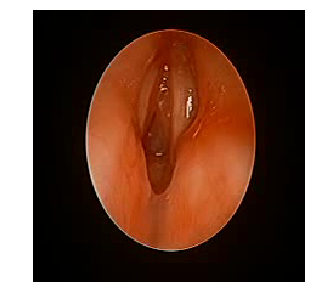

In [83]:
cv2img = cv2.imread('/storage/vocal_cords_and_rings_data/data/videos/frame_5421.png')
img = open_image('/storage/vocal_cords_and_rings_data/data/videos/frame_5421.png')
img.show(figsize=(5,5))
# np.unique(mask.data)
# image.show()

In [138]:
# img = np.asarray(img.data, 'uint8')

# mask = open_mask('/storage/vocal_chords_and_rings_data/data/videos/mask_5421.png')
# mask = np.asarray(mask.data, 'uint8')

# idx1 = (mask==2)
# mask2 = np.zeros((224, 224))
# mask2 = mask[idx1]
# np.unique(mask2), mask.shape, np.unique(mask), np.unique(idx1*1), idx1.shape
mask = cv2.imread('/storage/vocal_cords_and_rings_data/data/videos/mask_5421.png')
img = cv2.imread('/storage/vocal_cords_and_rings_data/data/videos/frame_5421.png')

output = np.zeros((224,224))
alpha = 0.6
beta = (1-alpha)

mask2 = cv2.cvtColor(mask*10, cv2.COLOR_BGR2HLS)
output = cv2.addWeighted(img, alpha, mask2, beta, 0.0)

np.unique(output)

rgb_ = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

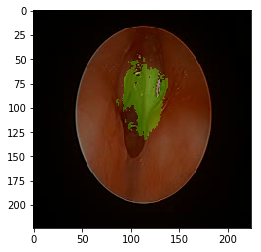

In [250]:
rgb_ = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_)

In [237]:
alpha = 0.5
# w = h = 224

red_img = np.zeros((h,w,3), np.uint8)
red_img[:,:] = (0,0,255)
red_img = np.transpose(red_img, (2,1,0))

In [164]:

# img[mask.data==2] = (0, 0, 255)
# overlay = img.copy()
# overlay = cv2.bitwise_and(img, img, mask=mask.np.masked_where)
# overlay[mask.data==2] = (0, 0, 255)
# overlay = img[0][mask.data==2]



# print(red_img.shape)
# print(img.shape)

# img=(img*(1-alpha)+alpha*red_img)
# output = img.copy()
# overlay = img.copy()
# cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
output = cv2.bitwise_and(img,idx*1) #times 1 for explicit conversion from bool to int
output = np.transpose(output, (2,1,0))

# from PIL import Image as IMAGE
# im = IMAGE.fromarray(img)

# plt.imshow(np.transpose(output, (2,1,0)))
# plt.title('overlaid')
# plt.show()


# overlay.shape, img.shape, mask.shape

In [167]:
import PIL.Image as IMAGE
im = IMAGE.fromarray(output)
# im.show()

from matplotlib.pyplot import imshow as imsh
imsh(im)
np.unique(im)

array([0], dtype=uint8)

In [147]:
alpha = 0.5
output = img.copy()
cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

array([[[  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0]],

       [[  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0],
        [  0,   0,   0,   0, ...,   0,   0,   0,   0]],

       [[223, 223, 223, 223, ..., 223, 223, 223, 223],
        [223, 223, 223, 223, ..., 2

# Evaluate Frame by Frame (Debugging)

In [71]:
??open_image
# ??ImageBBox
# ??ImagePoints
# ??Image

In [6]:
frame = cv2.imread(str(path/'vocal_cords_and_rings_data/data/videos/frame_5410.png'), cv2.IMREAD_COLOR)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#rgb_ = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# plt.imshow(frame)
# t = bgr_to_tensor(frame)

t = PIL.Image.fromarray(frame)
t = pil2tensor(t.convert("RGB"), np.float32).div_(255)
t_new = Image(t)


torch.Size([1, 224, 224])


Text(0.5, 1.0, 'histogram')

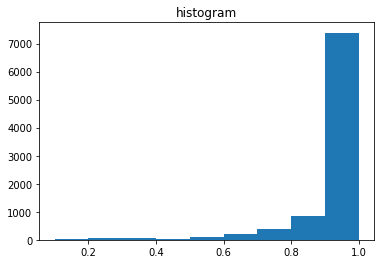

In [21]:
#Predict
prediction = learn.predict(t_new)
# print("PRED SHAPE: {}".format(prediction))
p = prediction[1] #prediction data
p1 = np.array(p)
p1.astype('uint8')

p3 = p1
p3 = p3.squeeze()
#     print("p3shape: {}".format(p3.shape))
#     plt.imshow(p3)
#     plt.title('frame # {}'.format(ctr))
#     plt.show()

    
p4 = np.expand_dims(p3, axis=2)
p4 = p4.astype('uint8')
mask = cv2.cvtColor(p4, cv2.COLOR_GRAY2BGR)

#TESTS:
print(prediction[1].size())
a = np.unique(np.array(prediction[2][0]))

plt.hist(a, bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) 
plt.title("histogram") 


# print (prediction[2][0])
# im_mask = PIL.Image.fromarray(mask*100)
# im_mask
# overlay = PIL.Image.fromarray(overlay_mask(frame, mask))
# overlay

### This histogram shows that the network is fairly confident in its predictions

In [130]:
??learn.predict